## Modeling
### Class Definition:
`ImbalancedBinaryCVSplit`: Split imbalanced binary target data set into N splits of balanced Test Sets to be used for model training and tested with X% of original data set, also imbalanced.

### Import libs

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil
from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer, QuantileTransformer
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    log_loss,
    RocCurveDisplay)
from sklearn.utils import shuffle
from tqdm.keras import TqdmCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
import tensorflow as tf
import keras.backend as K

# Plotting settings
sns.set_style("darkgrid")
sns.set_context("paper")

# Random seeds for reproducibility
random_state = 42
np.random.seed(random_state)
random.seed(random_state)


### Function definition

In [2]:
def remove_outliers(X, y, random_state=random_state):
    out = IsolationForest(random_state=random_state)
    out_pred = out.fit_predict(X)
    X = X[out_pred == 1]
    y = y.loc[X.index]
    return X, y

In [3]:
def balanced_logloss(y_true, y_score):
    """
    Calculates balanced logloss.
    """
    if len(y_score.shape) == 1 or (len(y_score.shape) == 2 and y_score.shape[-1] == 1):
        y_score = np.hstack((1 - y_score, y_score))

    y_true = np.array(y_true)
    y_score = np.array(y_score)
    y_score = y_score / y_score.sum(axis=1)[:, None]
    y_score = np.clip(y_score, 1e-15, 1 - 1e-15)

    nc = np.bincount(y_true)

    y_0 = np.array([1 if i == 0 else 0 for i in y_true])
    y_1 = np.array([1 if i == 1 else 0 for i in y_true])
    
    if nc[0] > 0:
        log_loss_0 = - (1 * np.sum(y_0 * np.log(y_score[:, 0]))) / nc[0]
    else:
        log_loss_0 = 0
    if nc[1] > 0:
        log_loss_1 = - (1 * np.sum(y_1 * np.log(y_score[:, 1]))) / nc[1]
    else:
        log_loss_1 = 0
        
    balanced_logloss = (log_loss_0 + log_loss_1) / 2
    return balanced_logloss


In [80]:
log_loss(y_test, y_, eps=1e-15)

0.3246128241768029

### Class Definition

In [4]:
class LogScaler():
    def __init__(self):
        pass

    def fit_transform(self, X):
        log = np.log1p(X)
        log_mean = np.mean(log, axis=0)
        X = log - log_mean
        return X
    
    def transform(self, X):
        log = np.log1p(X)
        log_mean = np.mean(log, axis=0)
        X = log - log_mean
        return X

In [5]:
class ImbalancedBinaryCVSplit:
    def __init__(self, X, y, test_size = 0.1, random_state = 42):
        # Define imbalanced classes
        y_cls_min = y.value_counts(ascending=True).index[0]
        y_cls_max = y.value_counts(ascending=True).index[-1]
        
        # Split Train / Test for CV
        X_train_cv, X_test, y_train_cv, y_test = train_test_split(X, y, test_size=test_size, 
                                                                  random_state=random_state, stratify=y)

        # Separate classes for balanced cross validation
        y_train_min = y_train_cv[y_train_cv == y_cls_min]
        y_train_max = y_train_cv[y_train_cv == y_cls_max]
        X_train_min = X_train_cv.loc[y_train_min.index]
        X_train_max = X_train_cv.loc[y_train_max.index]
        
        self.y_train_max = y_train_max
        self.y_train_min = y_train_min
        self.X_train_max = X_train_max
        self.X_train_min = X_train_min
        self.X_test = X_test
        self.y_test = y_test
        
    def split(self):
        # Calculate number of splits needed to use all data
        n_splits = ceil(len(self.y_train_max) / len(self.y_train_min))

        # Chech if all observations of max class was used
        list_max = list(self.y_train_max.index)
        
        # Split balanced train sets
        list_splits = list_max.copy()
        random.shuffle(list_splits)
        
        # Return dict of splits
        splits = {}

        for split in range(n_splits):
            # Include new random observations for last fold
            if len(list_splits) < len(self.y_train_min):
                diff = len(self.y_train_min) - len(list_splits)
                list_splits.extend(random.sample(list(set(self.y_train_max.index) - set(list_splits)), diff))

            # Use elements from list of 0's and remove than
            idx = list_splits[:len(self.y_train_min)]
            del list_splits[:len(self.y_train_min)]

            #Prepare train set
            X_t_s_max, y_t_s_max = self.X_train_max.loc[idx], self.y_train_max.loc[idx]

            # Add imbalanced class
            X_t_s, y_t_s = pd.concat([X_t_s_max, self.X_train_min]), pd.concat([y_t_s_max, self.y_train_min])

            # Shuffle train set
            X_train, y_train = shuffle(X_t_s, y_t_s)
            
            # Check if train/test sets are not overlapping
            assert len(set(y_train.index) & set(self.y_test.index)) == 0
            
            # Add to list
            splits[split] = (X_train, self.X_test, y_train, self.y_test)
            
            # Remove used max from list
            for i in y_train.index:
                if i in list_max:
                    list_max.remove(i)
            
        self.n_splits = n_splits
        self.split_test_size = len(self.y_test) / (len(y_train) + len(self.y_test))
        self.all_max_used = len(list_max) == 0

        return iter(splits.items())

## Data Loading

In [6]:
# Load data
test = pd.read_csv('../../../Data/Raw/test.csv')
train = pd.read_csv('../../../Data/Raw/train.csv')
greeks = pd.read_csv('../../../Data/Raw/greeks.csv')

# Remove spaces from column names
train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

# Drop ID column
train = train.drop(columns='Id')
test = test.drop(columns='Id')
greeks = greeks.drop(columns='Id')

# Remove rows with less than 1% missing values
train_missing = train.isnull().sum()
missing_cols = train_missing[train_missing > 0].index.tolist()
missing_cols.remove('BQ')
missing_cols.remove('EL')

# Get indexes of rows with missing values and drop them from train and greeks data sets
idx_missing = train[missing_cols][train[missing_cols].isnull().any(axis=1)].index
train = train.drop(idx_missing, axis=0).reset_index(drop=True)
greeks = greeks.drop(idx_missing, axis=0).reset_index(drop=True)

# Define features and target
X = train.drop(columns='Class')
y = train['Class']

# Encode categorical features
le = LabelEncoder()
X['EJ'] = le.fit_transform(X['EJ'])
test['EJ'] = le.transform(test['EJ'])

## Modeling

Fold 0 Init 0 Balanced Log Loss: 0.2084
Fold 0 Init 1 Balanced Log Loss: 0.2556
Fold 0 Init 2 Balanced Log Loss: 0.2222
Fold 0 Init 3 Balanced Log Loss: 0.1869
Fold 0 Init 4 Balanced Log Loss: 0.1821
Fold 0 Init 5 Balanced Log Loss: 0.2056
Fold 0 Init 6 Balanced Log Loss: 0.1778
Fold 0 Init 7 Balanced Log Loss: 0.2581
Fold 0 Init 8 Balanced Log Loss: 0.2131
Fold 0 Init 9 Balanced Log Loss: 0.2189
Fold 0 Balanced Log Loss: 0.1778
Fold 0 Accuracy: 0.9193548387096774


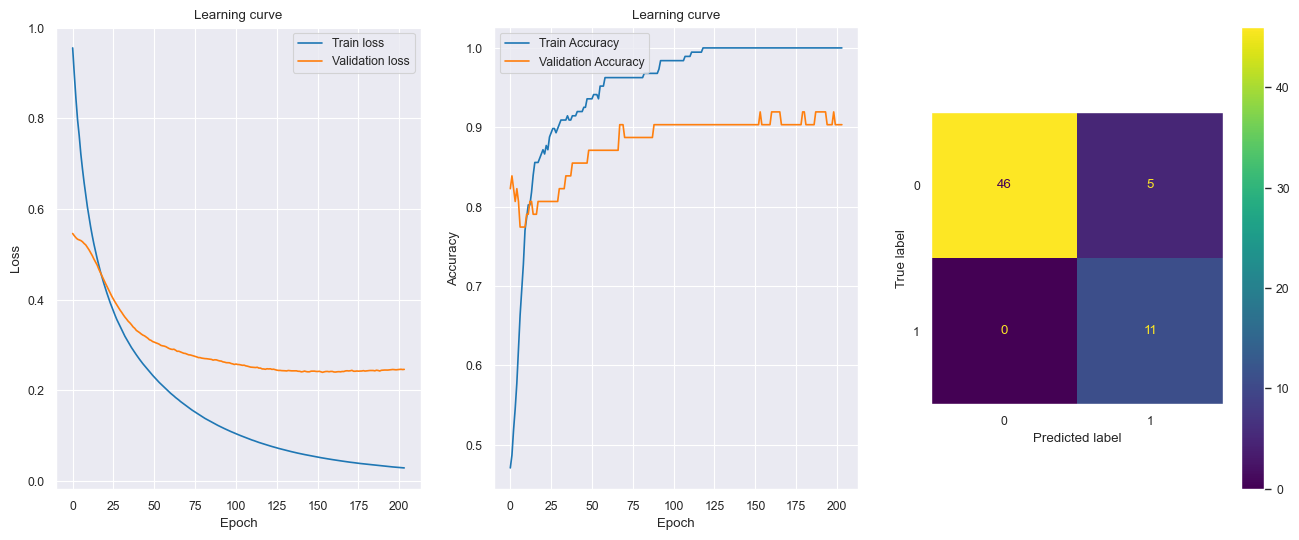

Fold 1 Init 0 Balanced Log Loss: 0.2051
Fold 1 Init 1 Balanced Log Loss: 0.1954
Fold 1 Init 2 Balanced Log Loss: 0.1810
Fold 1 Init 3 Balanced Log Loss: 0.2128
Fold 1 Init 4 Balanced Log Loss: 0.2278
Fold 1 Init 5 Balanced Log Loss: 0.2317
Fold 1 Init 6 Balanced Log Loss: 0.1805
Fold 1 Init 7 Balanced Log Loss: 0.2259
Fold 1 Init 8 Balanced Log Loss: 0.2292
Fold 1 Init 9 Balanced Log Loss: 0.2021
Fold 1 Balanced Log Loss: 0.1805
Fold 1 Accuracy: 0.9032258064516129


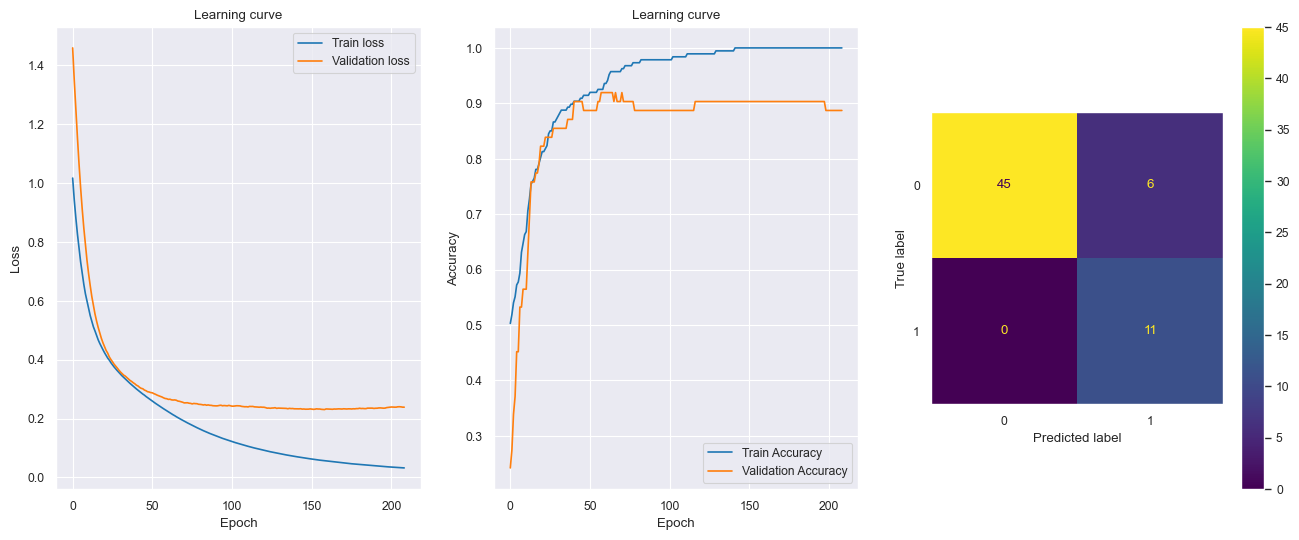

Fold 2 Init 0 Balanced Log Loss: 0.2627
Fold 2 Init 1 Balanced Log Loss: 0.2304
Fold 2 Init 2 Balanced Log Loss: 0.2475
Fold 2 Init 3 Balanced Log Loss: 0.2528
Fold 2 Init 4 Balanced Log Loss: 0.2529
Fold 2 Init 5 Balanced Log Loss: 0.2524
Fold 2 Init 6 Balanced Log Loss: 0.2221
Fold 2 Init 7 Balanced Log Loss: 0.2750
Fold 2 Init 8 Balanced Log Loss: 0.2690
Fold 2 Init 9 Balanced Log Loss: 0.2634
Fold 2 Balanced Log Loss: 0.2221
Fold 2 Accuracy: 0.8870967741935484


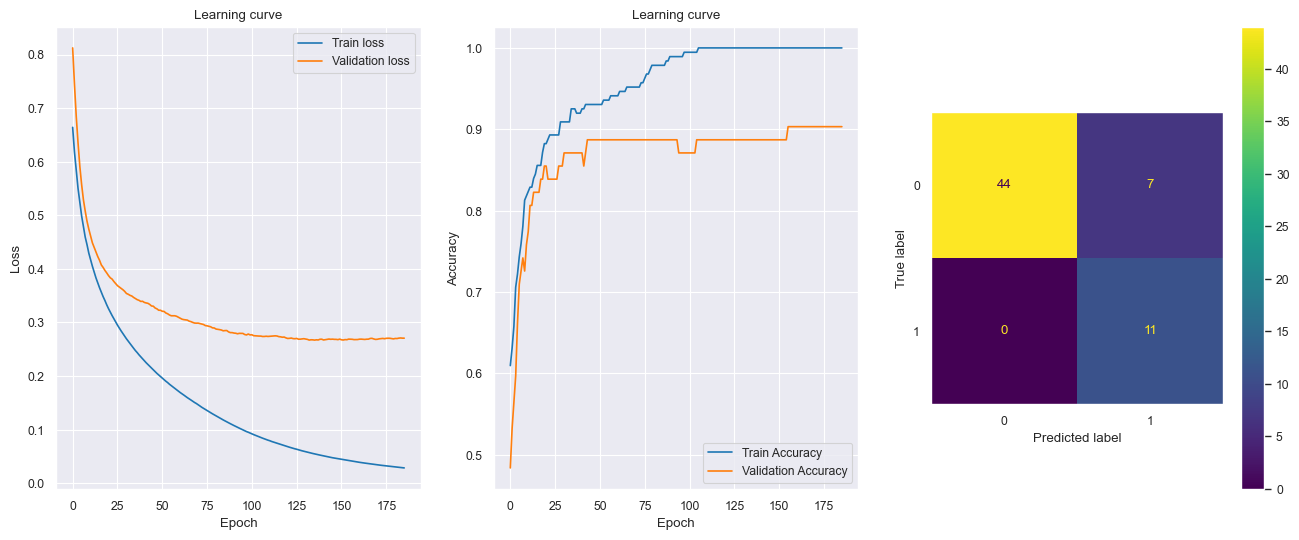

Fold 3 Init 0 Balanced Log Loss: 0.2508
Fold 3 Init 1 Balanced Log Loss: 0.2911
Fold 3 Init 2 Balanced Log Loss: 0.2535
Fold 3 Init 3 Balanced Log Loss: 0.2404
Fold 3 Init 4 Balanced Log Loss: 0.2631
Fold 3 Init 5 Balanced Log Loss: 0.2151
Fold 3 Init 6 Balanced Log Loss: 0.2294
Fold 3 Init 7 Balanced Log Loss: 0.2415
Fold 3 Init 8 Balanced Log Loss: 0.2432
Fold 3 Init 9 Balanced Log Loss: 0.2443
Fold 3 Balanced Log Loss: 0.2151
Fold 3 Accuracy: 0.9032258064516129


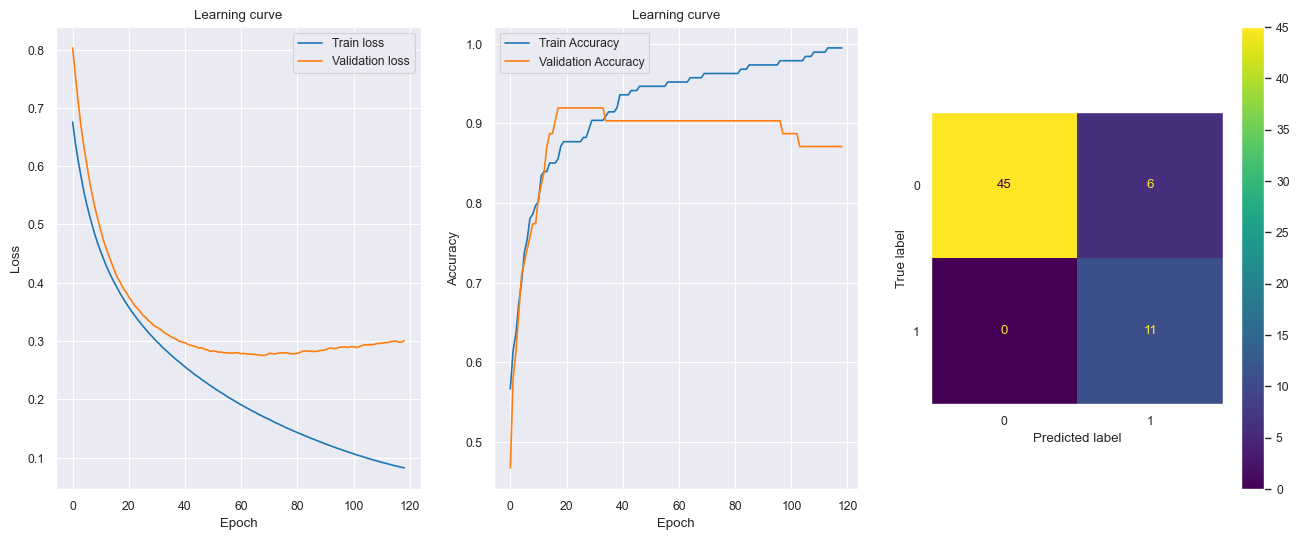

Fold 4 Init 0 Balanced Log Loss: 0.2902
Fold 4 Init 1 Balanced Log Loss: 0.3811
Fold 4 Init 2 Balanced Log Loss: 0.3267
Fold 4 Init 3 Balanced Log Loss: 0.3254
Fold 4 Init 4 Balanced Log Loss: 0.3357
Fold 4 Init 5 Balanced Log Loss: 0.2941
Fold 4 Init 6 Balanced Log Loss: 0.3187
Fold 4 Init 7 Balanced Log Loss: 0.3247
Fold 4 Init 8 Balanced Log Loss: 0.3245
Fold 4 Init 9 Balanced Log Loss: 0.3060
Fold 4 Balanced Log Loss: 0.2902
Fold 4 Accuracy: 0.8709677419354839


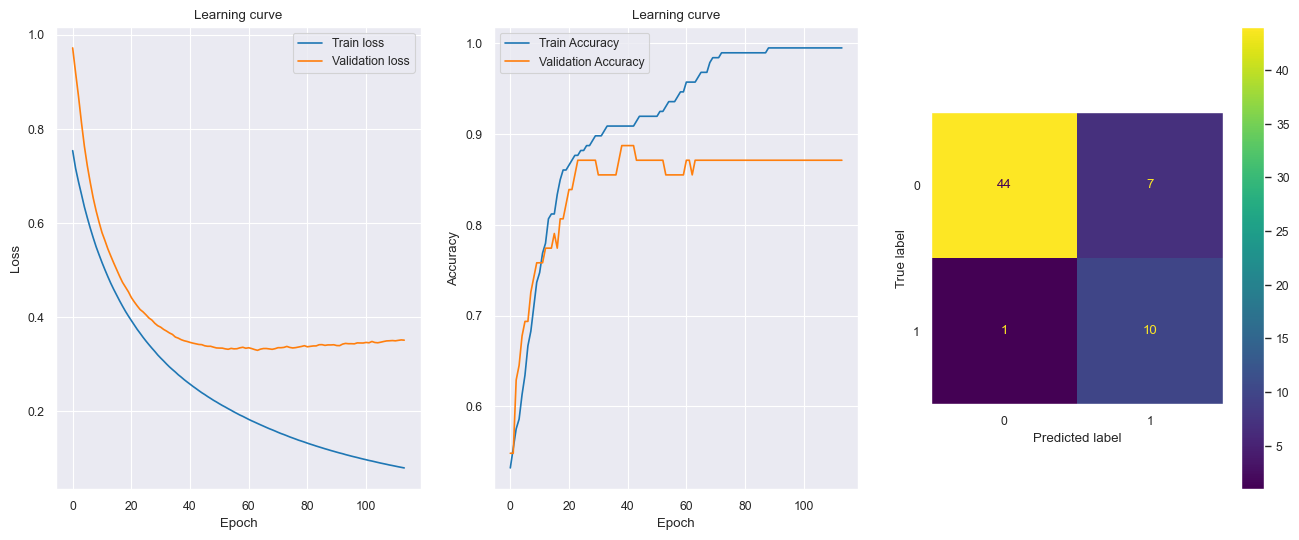

Best Fold: 0
Best Balanced Log Loss: 0.1777932726802317

CPU times: user 1min 55s, sys: 20.8 s, total: 2min 16s
Wall time: 1min 44s


In [26]:
%%time

# Encode categorical features
le = LabelEncoder()
X['EJ'] = le.fit_transform(X['EJ'])

cv = ImbalancedBinaryCVSplit(X, y, test_size=0.1, random_state=random_state)

cv_data = []
best_score = 100
best_fold = None
best_model = None
for fold, (X_train, X_test, y_train, y_test) in cv.split():
    # Impute missing values
    knn_imputer = KNNImputer(n_neighbors=5)
    X_train = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(knn_imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

    # Remove outliers
    X_train, y_train = remove_outliers(X_train, y_train, random_state=random_state)

    # Scale features
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

    # PCA
    pca = PCA(n_components=28, random_state=random_state)
    X_train = pd.DataFrame(pca.fit_transform(X_train), index=X_train.index)
    X_test = pd.DataFrame(pca.transform(X_test), index=X_test.index)
    
    # Multiple initializations
    n_init = 10

    init_best_score = 100
    history = None
    init_best_model = None
    for init in range(n_init):
        # Neural Network Architecture
        model = Sequential()
        model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        # Compile Neural Network
        opt = Adam(learning_rate=0.001)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

        # Callbacks
        es = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

        # Train Neural Network
        h = model.fit(X_train, y_train, epochs=10000, batch_size=32, 
                      callbacks=es, verbose=0, validation_data=(X_test, y_test))

        # Evaluate Initializations
        y_score = model.predict(X_test, verbose=0)
        score = balanced_logloss(y_test, y_score)
        print(f'Fold {fold} Init {init} Balanced Log Loss: {score:.4f}')
        
        # Save best initialization
        if score < init_best_score:
            init_best_score = score
            init_best_model = model
            history = h
    
    # Evaluate Neural Network
    y_score = init_best_model.predict(X_test, verbose=0)
    y_pred = np.where(y_score > 0.5, 1, 0)
    score = balanced_logloss(y_test, y_score)
    print(f'Fold {fold} Balanced Log Loss: {score:.4f}')
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Fold {fold} Accuracy: {accuracy}')

    # Save data for plotting
    cv_data.append({
        'label_encoder' : le,
        'knn_imputer' : knn_imputer,
        'scaler' : scaler,
        'pca' : pca,
        'model' : init_best_model
    })

    # Save best model
    if score < best_score:
        best_score = score
        best_fold = fold
        best_model = init_best_model

    # Plot learning curves
    fig, axs = plt.subplots(1, 3, figsize=(16, 6))

    plt.subplot(131)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(132)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    ax = plt.subplot(133)
    ConfusionMatrixDisplay(cm).plot(ax=ax)
    plt.grid(False)
    plt.show()

# Print best model
print(f'Best Fold: {best_fold}')
print(f'Best Balanced Log Loss: {best_score}\n')

## Evaluation

In [27]:
cv_data[best_fold]

{'label_encoder': LabelEncoder(),
 'knn_imputer': KNNImputer(),
 'scaler': StandardScaler(),
 'pca': PCA(n_components=28, random_state=42),
 'model': <keras.engine.sequential.Sequential at 0x28dd304f0>}

In [28]:
test_scaled = cv_data[best_fold]['scaler'].transform(test)
test_pca = cv_data[best_fold]['pca'].transform(test_scaled)
test_pred = cv_data[best_fold]['model'].predict(test_pca, verbose=0)
test_pred

/Users/brunomotta/miniconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


array([[0.00218817],
       [0.00218817],
       [0.00218817],
       [0.00218817],
       [0.00218818]], dtype=float32)

Fold 0 Init 0 Balanced Log Loss: 0.3243
Fold 0 Init 1 Balanced Log Loss: 0.3338
Fold 0 Init 2 Balanced Log Loss: 0.2772
Fold 0 Init 3 Balanced Log Loss: 0.2987
Fold 0 Init 4 Balanced Log Loss: 0.2567
Fold 0 Balanced Log Loss: 0.2567
Fold 0 Accuracy: 0.9193548387096774


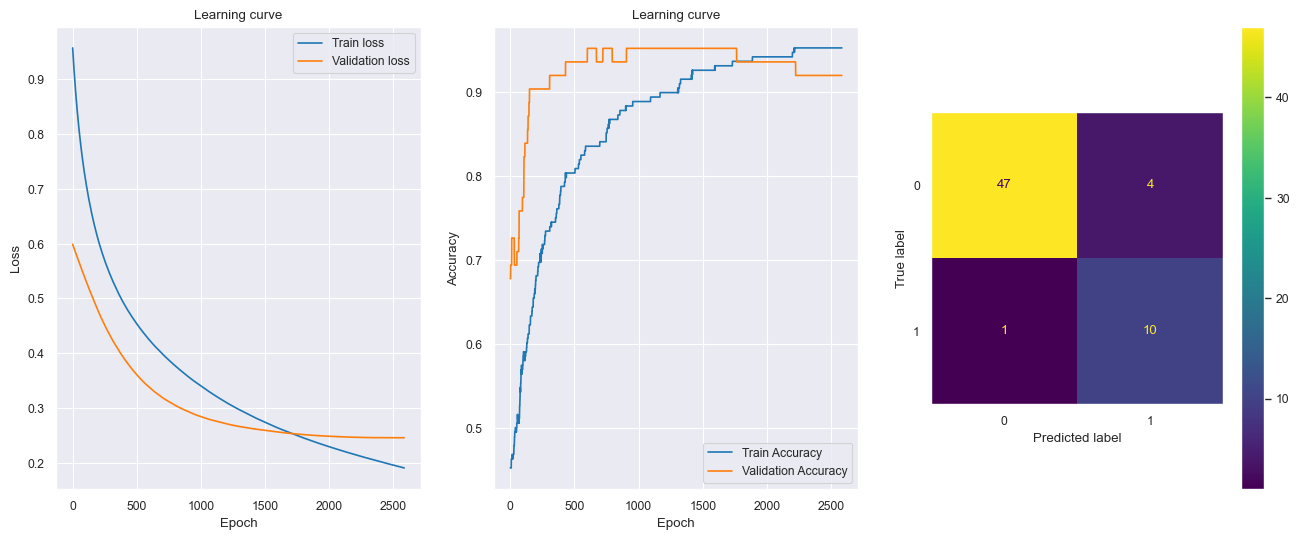

Fold 1 Init 0 Balanced Log Loss: 0.8802
Fold 1 Init 1 Balanced Log Loss: 0.2639
Fold 1 Init 2 Balanced Log Loss: 0.1576
Fold 1 Init 3 Balanced Log Loss: 0.2337
Fold 1 Init 4 Balanced Log Loss: 0.2787
Fold 1 Balanced Log Loss: 0.1576
Fold 1 Accuracy: 0.9032258064516129


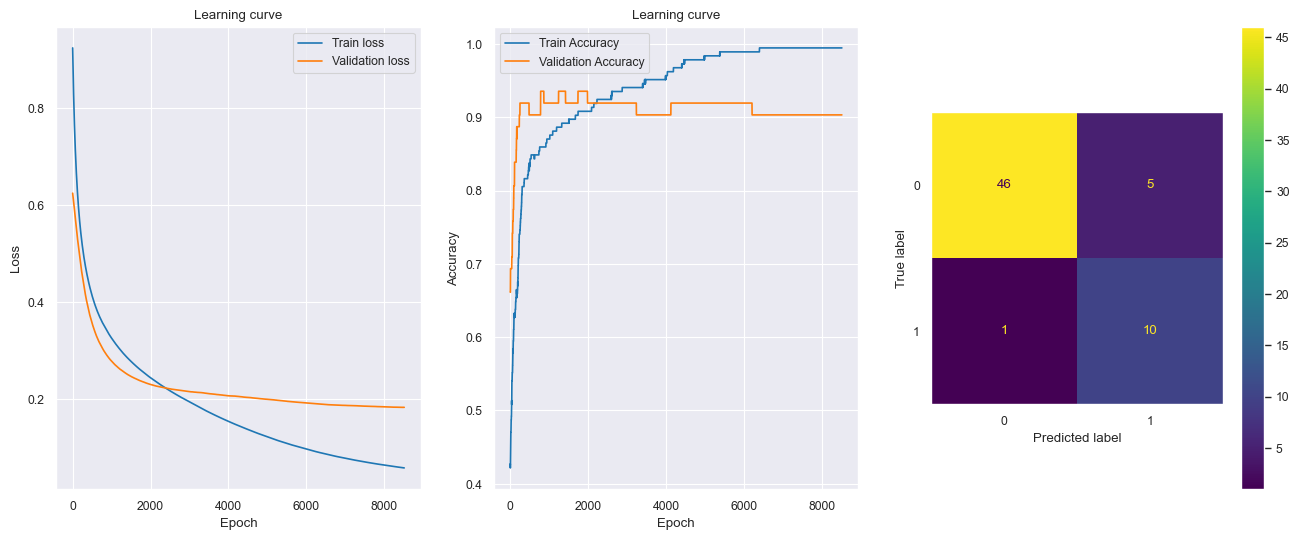

Fold 2 Init 0 Balanced Log Loss: 0.3379
Fold 2 Init 1 Balanced Log Loss: 0.2843
Fold 2 Init 2 Balanced Log Loss: 0.2602
Fold 2 Init 3 Balanced Log Loss: 0.2756
Fold 2 Init 4 Balanced Log Loss: 0.2891
Fold 2 Balanced Log Loss: 0.2602
Fold 2 Accuracy: 0.8548387096774194


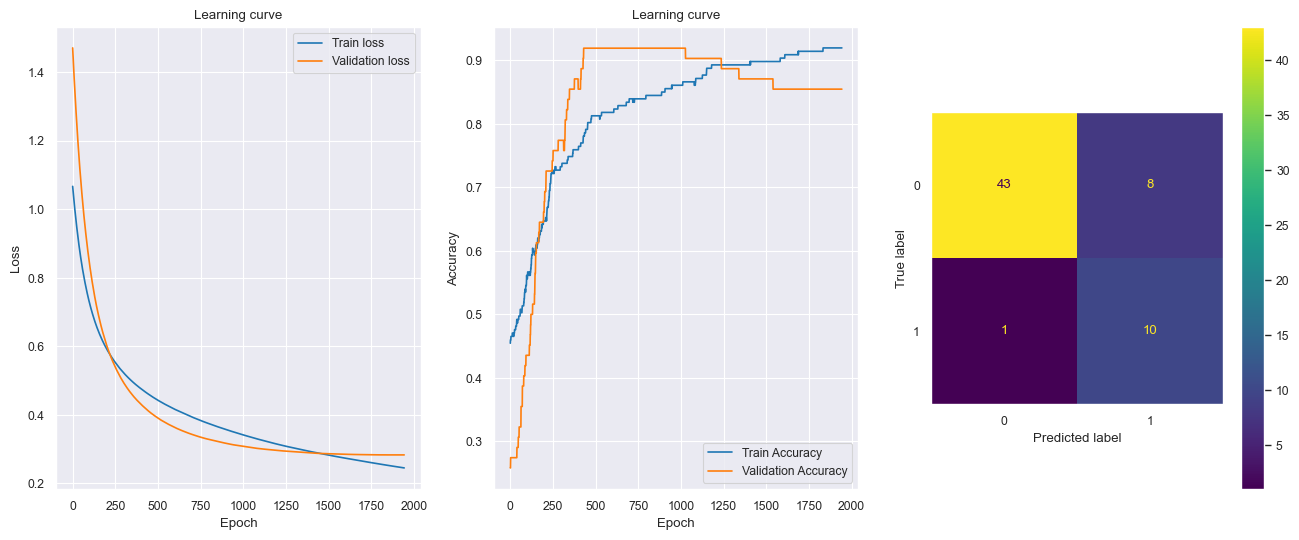

Fold 3 Init 0 Balanced Log Loss: 0.2157
Fold 3 Init 1 Balanced Log Loss: 0.3148
Fold 3 Init 2 Balanced Log Loss: 0.2846
Fold 3 Init 3 Balanced Log Loss: 0.2439
Fold 3 Init 4 Balanced Log Loss: 0.2563
Fold 3 Balanced Log Loss: 0.2157
Fold 3 Accuracy: 0.8870967741935484


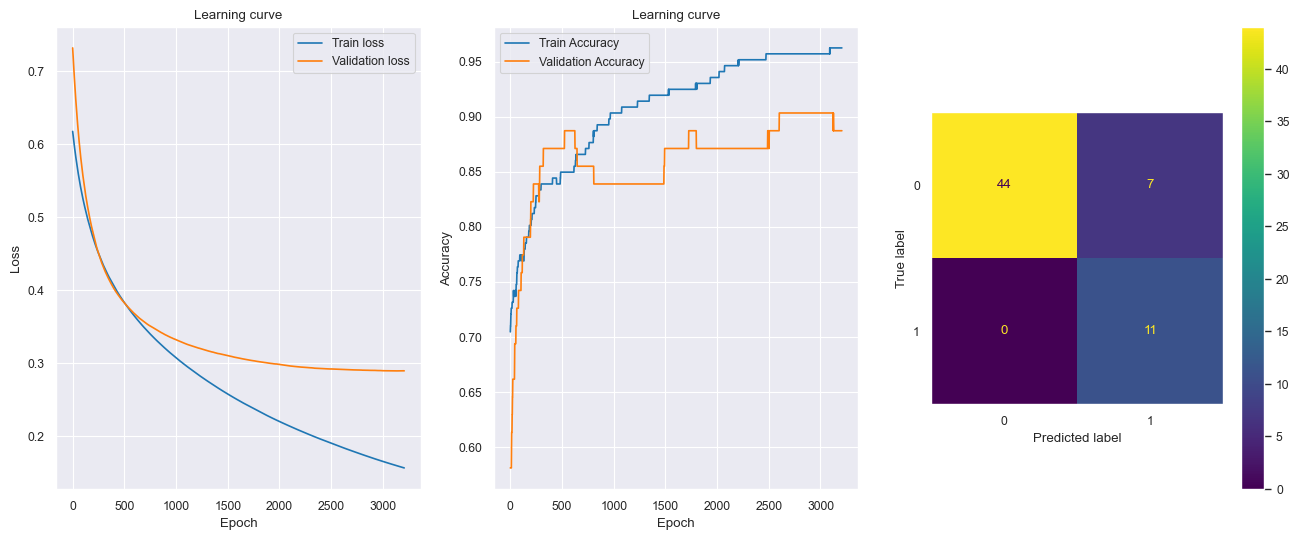

Fold 4 Init 0 Balanced Log Loss: 0.2022
Fold 4 Init 1 Balanced Log Loss: 0.2174
Fold 4 Init 2 Balanced Log Loss: 0.2100
Fold 4 Init 3 Balanced Log Loss: 0.1953
Fold 4 Init 4 Balanced Log Loss: 0.2035
Fold 4 Balanced Log Loss: 0.1953
Fold 4 Accuracy: 0.9354838709677419


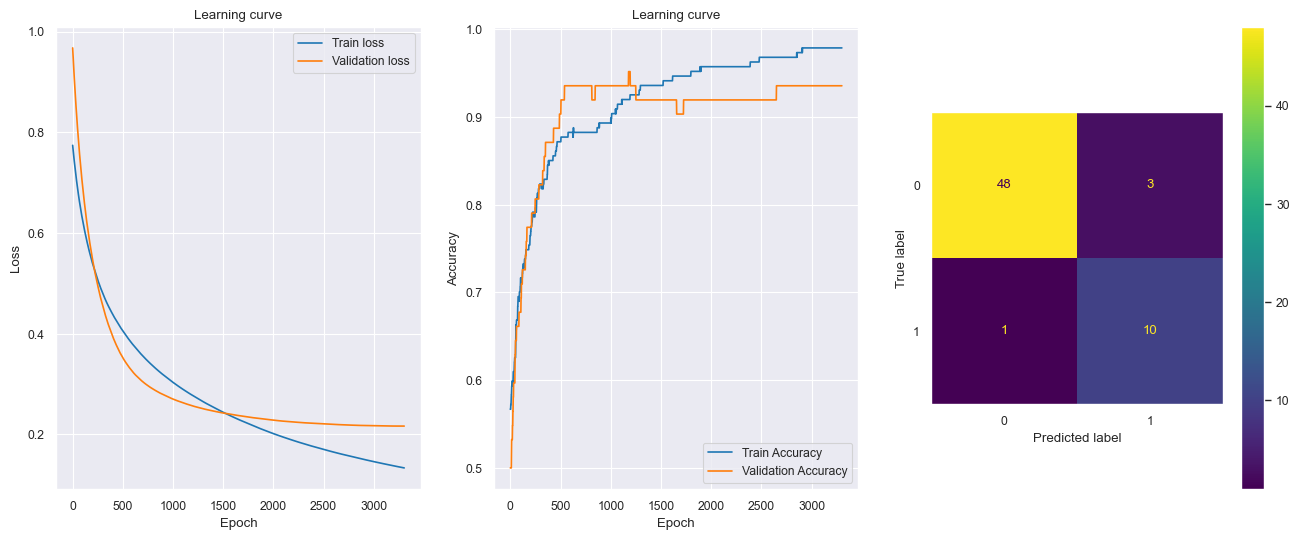

Best Fold: 1
Best Balanced Log Loss: 0.15762499011308703

CPU times: user 14min 11s, sys: 1min 28s, total: 15min 40s
Wall time: 13min 20s


In [23]:
%%time

# Encode categorical features
le = LabelEncoder()
X['EJ'] = le.fit_transform(X['EJ'])

cv = ImbalancedBinaryCVSplit(X, y, test_size=0.1, random_state=random_state)

cv_data = []
best_score = 100
best_fold = None
best_model = None
for fold, (X_train, X_test, y_train, y_test) in cv.split():
    # Impute missing values
    knn_imputer = KNNImputer(n_neighbors=5)
    X_train = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(knn_imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

    # Remove outliers
    X_train, y_train = remove_outliers(X_train, y_train, random_state=random_state)

    # Scale features
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

    # PCA
    pca = PCA(n_components=28, random_state=random_state)
    X_train = pd.DataFrame(pca.fit_transform(X_train), index=X_train.index)
    X_test = pd.DataFrame(pca.transform(X_test), index=X_test.index)
    
    # Multiple initializations
    n_init = 5

    init_best_score = 100
    history = None
    init_best_model = None
    for init in range(n_init):
        # Neural Network Architecture
        model = Sequential()
        model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        # Compile Neural Network
        opt = SGD(learning_rate=0.001) #! CHANGED OPTIMIZER
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

        # Callbacks
        es = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

        # Train Neural Network
        h = model.fit(X_train, y_train, epochs=10000, batch_size=32, 
                      callbacks=es, verbose=0, validation_data=(X_test, y_test))

        # Evaluate Initializations
        y_score = model.predict(X_test, verbose=0)
        score = balanced_logloss(y_test, y_score)
        print(f'Fold {fold} Init {init} Balanced Log Loss: {score:.4f}')
        
        # Save best initialization
        if score < init_best_score:
            init_best_score = score
            init_best_model = model
            history = h
    
    # Evaluate Neural Network
    y_score = init_best_model.predict(X_test, verbose=0)
    y_pred = np.where(y_score > 0.5, 1, 0)
    score = balanced_logloss(y_test, y_score)
    print(f'Fold {fold} Balanced Log Loss: {score:.4f}')
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Fold {fold} Accuracy: {accuracy}')

    # Save data for plotting
    cv_data.append({
        'label_encoder' : le,
        'knn_imputer' : knn_imputer,
        'scaler' : scaler,
        'pca' : pca,
        'model' : init_best_model
    })

    # Save best model
    if score < best_score:
        best_score = score
        best_fold = fold
        best_model = init_best_model

    # Plot learning curves
    fig, axs = plt.subplots(1, 3, figsize=(16, 6))

    plt.subplot(131)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(132)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    ax = plt.subplot(133)
    ConfusionMatrixDisplay(cm).plot(ax=ax)
    plt.grid(False)
    plt.show()

# Print best model
print(f'Best Fold: {best_fold}')
print(f'Best Balanced Log Loss: {best_score}\n')

## Evaluation

In [24]:
cv_data[best_fold]

{'label_encoder': LabelEncoder(),
 'knn_imputer': KNNImputer(),
 'scaler': StandardScaler(),
 'pca': PCA(n_components=28, random_state=42),
 'model': <keras.engine.sequential.Sequential at 0x284d88670>}

In [25]:
test_scaled = cv_data[best_fold]['scaler'].transform(test)
test_pca = cv_data[best_fold]['pca'].transform(test_scaled)
test_pred = cv_data[best_fold]['model'].predict(test_pca, verbose=0)
test_pred

/Users/brunomotta/miniconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


array([[0.01105678],
       [0.01105678],
       [0.01105678],
       [0.01105678],
       [0.01105677]], dtype=float32)

Fold 0 Init 0 Balanced Log Loss: 0.2436
Fold 0 Init 1 Balanced Log Loss: 0.2875
Fold 0 Init 2 Balanced Log Loss: 0.2109
Fold 0 Init 3 Balanced Log Loss: 0.2315
Fold 0 Init 4 Balanced Log Loss: 0.2436
Fold 0 Balanced Log Loss: 0.2109
Fold 0 Accuracy: 0.8709677419354839


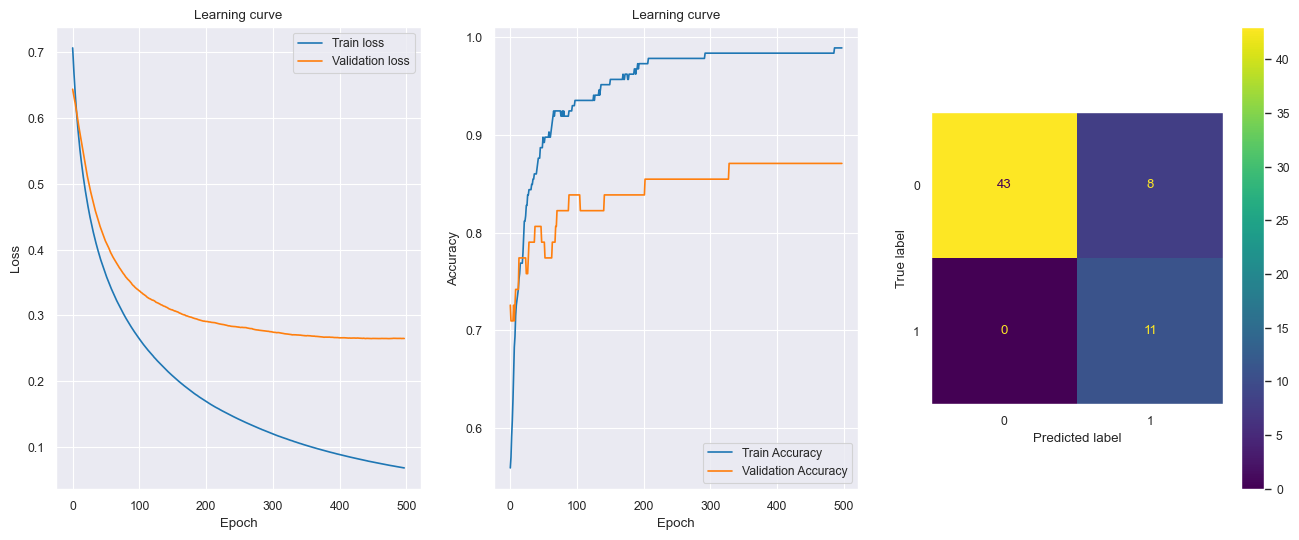

Fold 1 Init 0 Balanced Log Loss: 0.3099
Fold 1 Init 1 Balanced Log Loss: 0.2569
Fold 1 Init 2 Balanced Log Loss: 0.2259
Fold 1 Init 3 Balanced Log Loss: 0.1555
Fold 1 Init 4 Balanced Log Loss: 0.2743
Fold 1 Balanced Log Loss: 0.1555
Fold 1 Accuracy: 0.9354838709677419


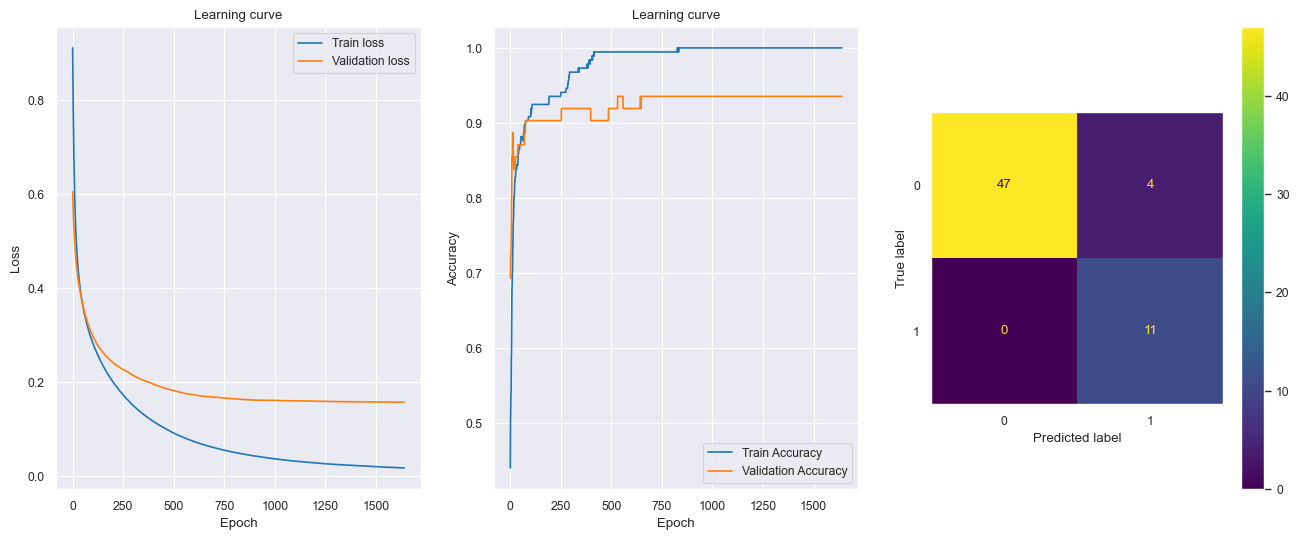

Fold 2 Init 0 Balanced Log Loss: 0.3151
Fold 2 Init 1 Balanced Log Loss: 0.2630
Fold 2 Init 2 Balanced Log Loss: 0.2686
Fold 2 Init 3 Balanced Log Loss: 0.2301
Fold 2 Init 4 Balanced Log Loss: 0.2041
Fold 2 Balanced Log Loss: 0.2041
Fold 2 Accuracy: 0.9032258064516129


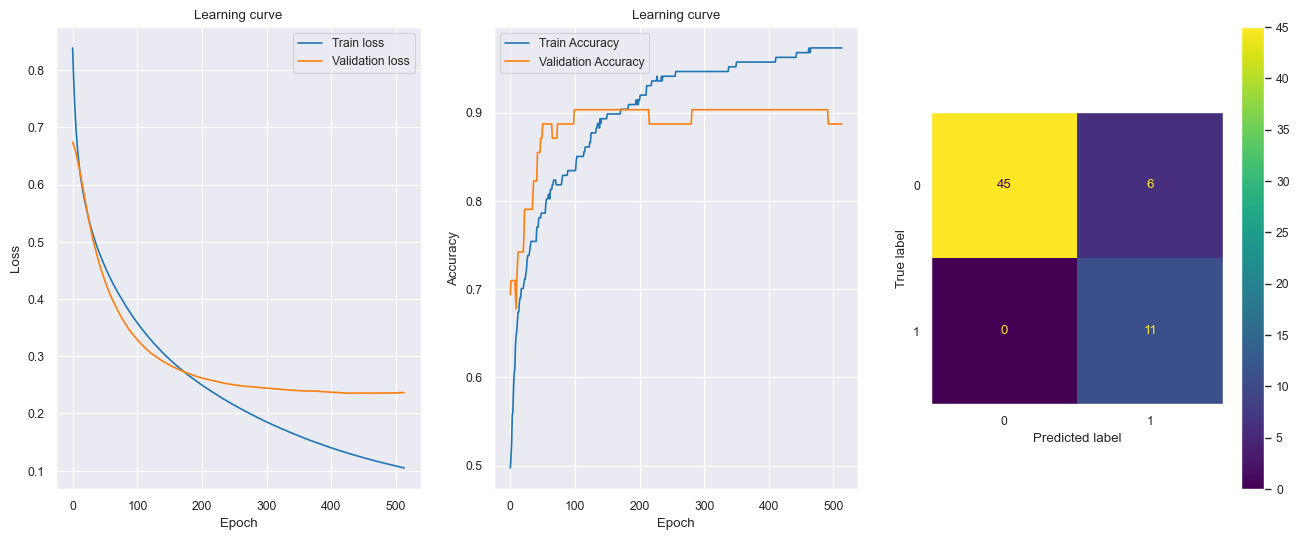

Fold 3 Init 0 Balanced Log Loss: 0.2632
Fold 3 Init 1 Balanced Log Loss: 0.2159
Fold 3 Init 2 Balanced Log Loss: 0.3563
Fold 3 Init 3 Balanced Log Loss: 0.2806
Fold 3 Init 4 Balanced Log Loss: 0.2867
Fold 3 Balanced Log Loss: 0.2159
Fold 3 Accuracy: 0.9032258064516129


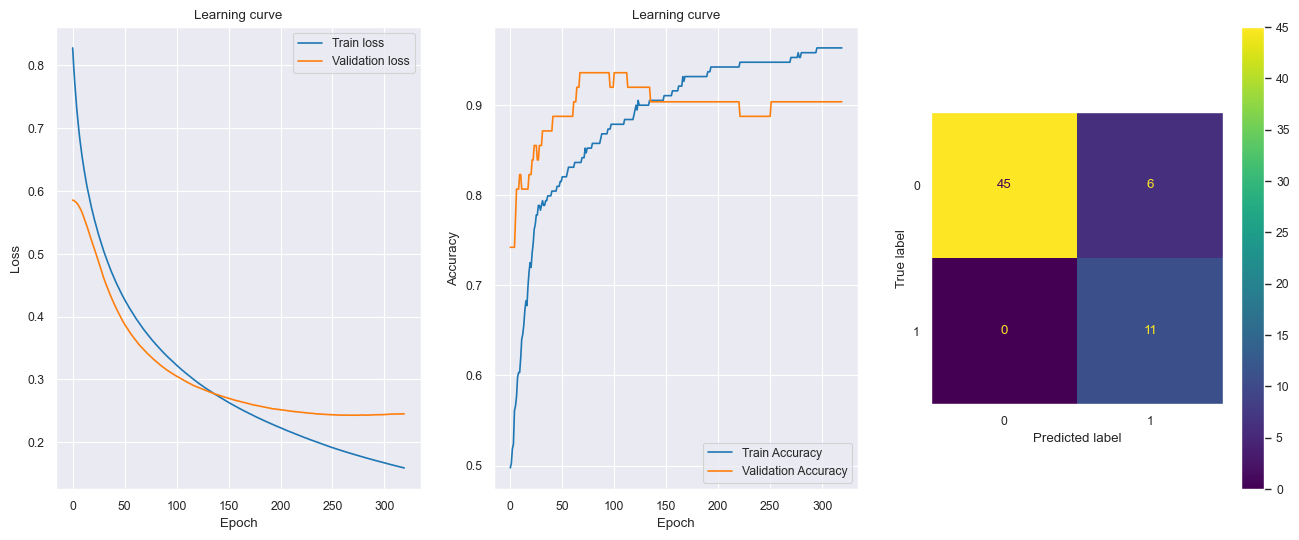

Fold 4 Init 0 Balanced Log Loss: 0.2966
Fold 4 Init 1 Balanced Log Loss: 0.2697
Fold 4 Init 2 Balanced Log Loss: 0.2529
Fold 4 Init 3 Balanced Log Loss: 0.2550
Fold 4 Init 4 Balanced Log Loss: 0.2464
Fold 4 Balanced Log Loss: 0.2464
Fold 4 Accuracy: 0.8870967741935484


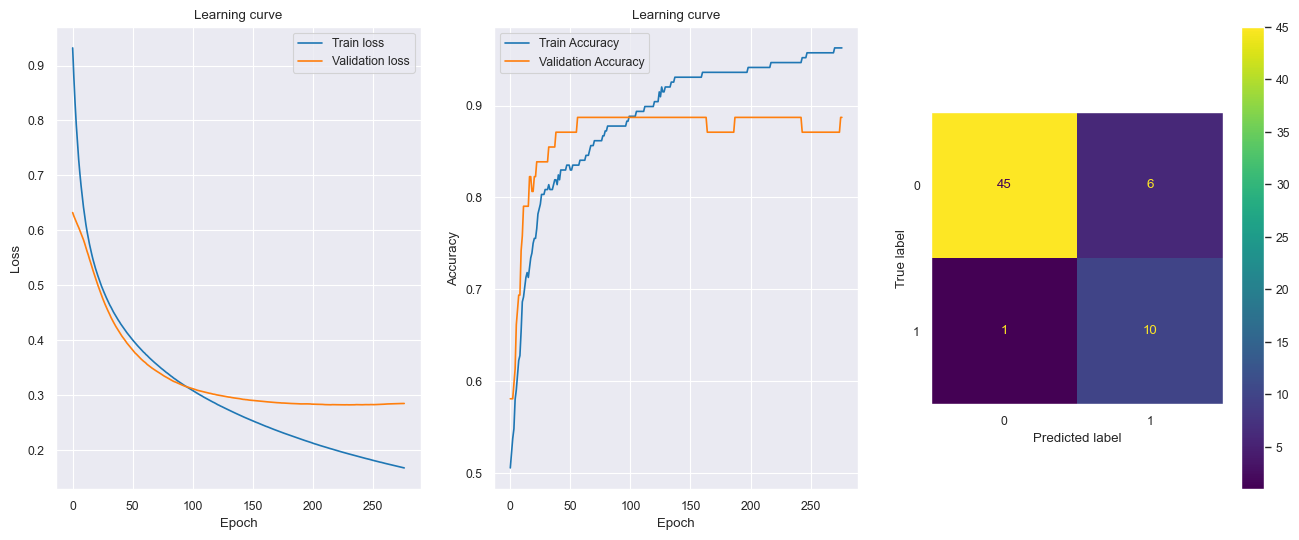

Best Fold: 1
Best Balanced Log Loss: 0.1554703359995041

CPU times: user 2min 43s, sys: 22.5 s, total: 3min 5s
Wall time: 2min 31s


In [29]:
%%time

# Encode categorical features
le = LabelEncoder()
X['EJ'] = le.fit_transform(X['EJ'])

cv = ImbalancedBinaryCVSplit(X, y, test_size=0.1, random_state=random_state)

cv_data = []
best_score = 100
best_fold = None
best_model = None
for fold, (X_train, X_test, y_train, y_test) in cv.split():
    # Impute missing values
    knn_imputer = KNNImputer(n_neighbors=5)
    X_train = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(knn_imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

    # Remove outliers
    X_train, y_train = remove_outliers(X_train, y_train, random_state=random_state)

    # Scale features
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

    # PCA
    pca = PCA(n_components=28, random_state=random_state)
    X_train = pd.DataFrame(pca.fit_transform(X_train), index=X_train.index)
    X_test = pd.DataFrame(pca.transform(X_test), index=X_test.index)
    
    # Multiple initializations
    n_init = 5

    init_best_score = 100
    history = None
    init_best_model = None
    for init in range(n_init):
        # Neural Network Architecture
        model = Sequential()
        model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        # Compile Neural Network
        opt = SGD(learning_rate=0.01) #! CHANGED LEARNING RATE
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

        # Callbacks
        es = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

        # Train Neural Network
        h = model.fit(X_train, y_train, epochs=10000, batch_size=32, 
                      callbacks=es, verbose=0, validation_data=(X_test, y_test))

        # Evaluate Initializations
        y_score = model.predict(X_test, verbose=0)
        score = balanced_logloss(y_test, y_score)
        print(f'Fold {fold} Init {init} Balanced Log Loss: {score:.4f}')
        
        # Save best initialization
        if score < init_best_score:
            init_best_score = score
            init_best_model = model
            history = h
    
    # Evaluate Neural Network
    y_score = init_best_model.predict(X_test, verbose=0)
    y_pred = np.where(y_score > 0.5, 1, 0)
    score = balanced_logloss(y_test, y_score)
    print(f'Fold {fold} Balanced Log Loss: {score:.4f}')
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Fold {fold} Accuracy: {accuracy}')

    # Save data for plotting
    cv_data.append({
        'label_encoder' : le,
        'knn_imputer' : knn_imputer,
        'scaler' : scaler,
        'pca' : pca,
        'model' : init_best_model
    })

    # Save best model
    if score < best_score:
        best_score = score
        best_fold = fold
        best_model = init_best_model

    # Plot learning curves
    fig, axs = plt.subplots(1, 3, figsize=(16, 6))

    plt.subplot(131)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(132)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    ax = plt.subplot(133)
    ConfusionMatrixDisplay(cm).plot(ax=ax)
    plt.grid(False)
    plt.show()

# Print best model
print(f'Best Fold: {best_fold}')
print(f'Best Balanced Log Loss: {best_score}\n')

In [30]:
cv_data[best_fold]

{'label_encoder': LabelEncoder(),
 'knn_imputer': KNNImputer(),
 'scaler': StandardScaler(),
 'pca': PCA(n_components=28, random_state=42),
 'model': <keras.engine.sequential.Sequential at 0x283b84ac0>}

In [31]:
test_scaled = cv_data[best_fold]['scaler'].transform(test)
test_pca = cv_data[best_fold]['pca'].transform(test_scaled)
test_pred = cv_data[best_fold]['model'].predict(test_pca, verbose=0)
test_pred

/Users/brunomotta/miniconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


array([[0.84221846],
       [0.84221846],
       [0.84221846],
       [0.84221846],
       [0.8422184 ]], dtype=float32)

Fold 0 Init 0 Balanced Log Loss: 0.2254
Fold 0 Init 1 Balanced Log Loss: 0.2223
Fold 0 Init 2 Balanced Log Loss: 0.1360
Fold 0 Init 3 Balanced Log Loss: 0.1749
Fold 0 Init 4 Balanced Log Loss: 0.2069
Fold 0 Init 5 Balanced Log Loss: 0.2219
Fold 0 Init 6 Balanced Log Loss: 0.1586
Fold 0 Init 7 Balanced Log Loss: 0.1206
Fold 0 Init 8 Balanced Log Loss: 0.1505
Fold 0 Init 9 Balanced Log Loss: 0.1615
Fold 0 Balanced Log Loss: 0.1206
Fold 0 Accuracy: 0.9354838709677419


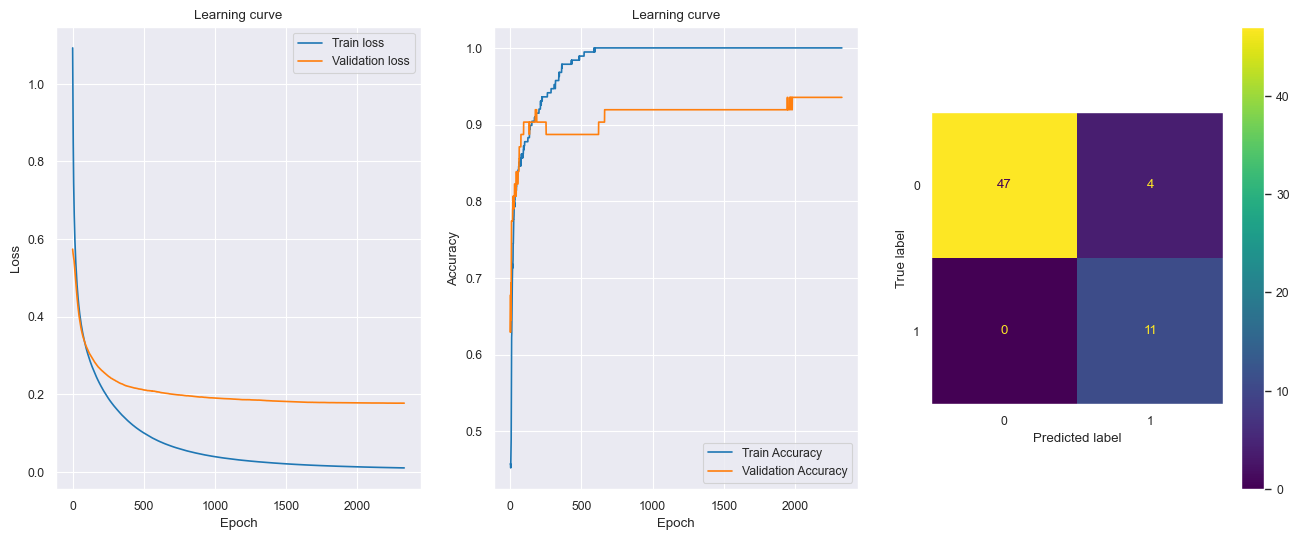

Fold 1 Init 0 Balanced Log Loss: 0.2288
Fold 1 Init 1 Balanced Log Loss: 0.2493
Fold 1 Init 2 Balanced Log Loss: 0.2539
Fold 1 Init 3 Balanced Log Loss: 0.2199
Fold 1 Init 4 Balanced Log Loss: 0.2456
Fold 1 Init 5 Balanced Log Loss: 0.2769
Fold 1 Init 6 Balanced Log Loss: 0.2427
Fold 1 Init 7 Balanced Log Loss: 0.2332
Fold 1 Init 8 Balanced Log Loss: 0.2393
Fold 1 Init 9 Balanced Log Loss: 0.2589
Fold 1 Balanced Log Loss: 0.2199
Fold 1 Accuracy: 0.8870967741935484


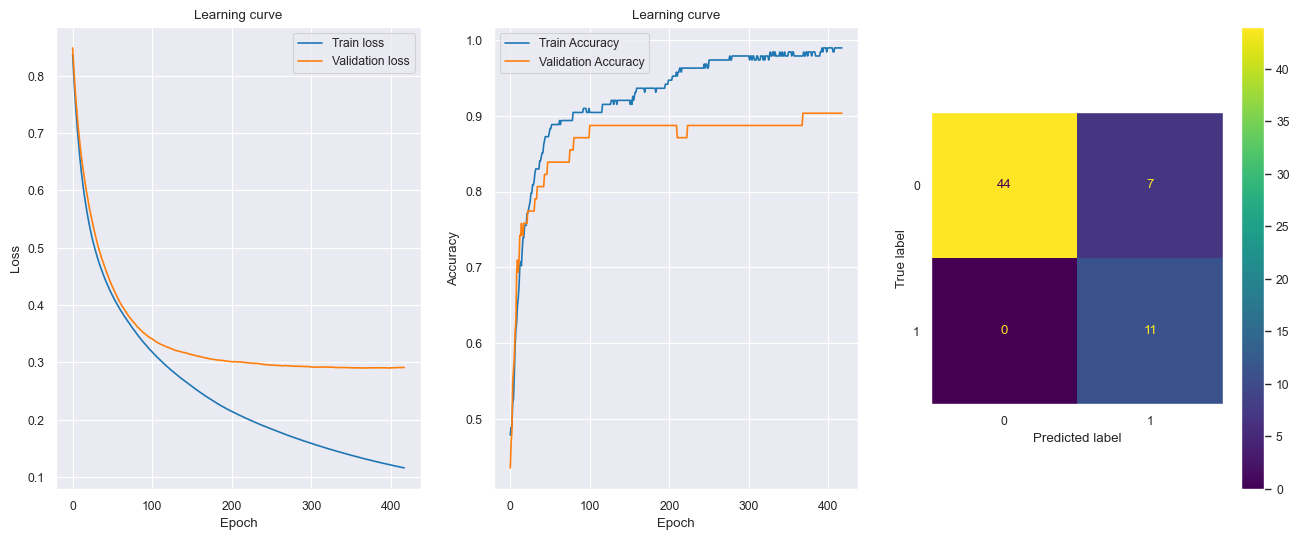

Fold 2 Init 0 Balanced Log Loss: 0.2821
Fold 2 Init 1 Balanced Log Loss: 0.2737
Fold 2 Init 2 Balanced Log Loss: 0.2718
Fold 2 Init 3 Balanced Log Loss: 0.2486
Fold 2 Init 4 Balanced Log Loss: 0.3244
Fold 2 Init 5 Balanced Log Loss: 0.2891
Fold 2 Init 6 Balanced Log Loss: 0.3077
Fold 2 Init 7 Balanced Log Loss: 0.2769
Fold 2 Init 8 Balanced Log Loss: 0.2792
Fold 2 Init 9 Balanced Log Loss: 0.2699
Fold 2 Balanced Log Loss: 0.2486
Fold 2 Accuracy: 0.9032258064516129


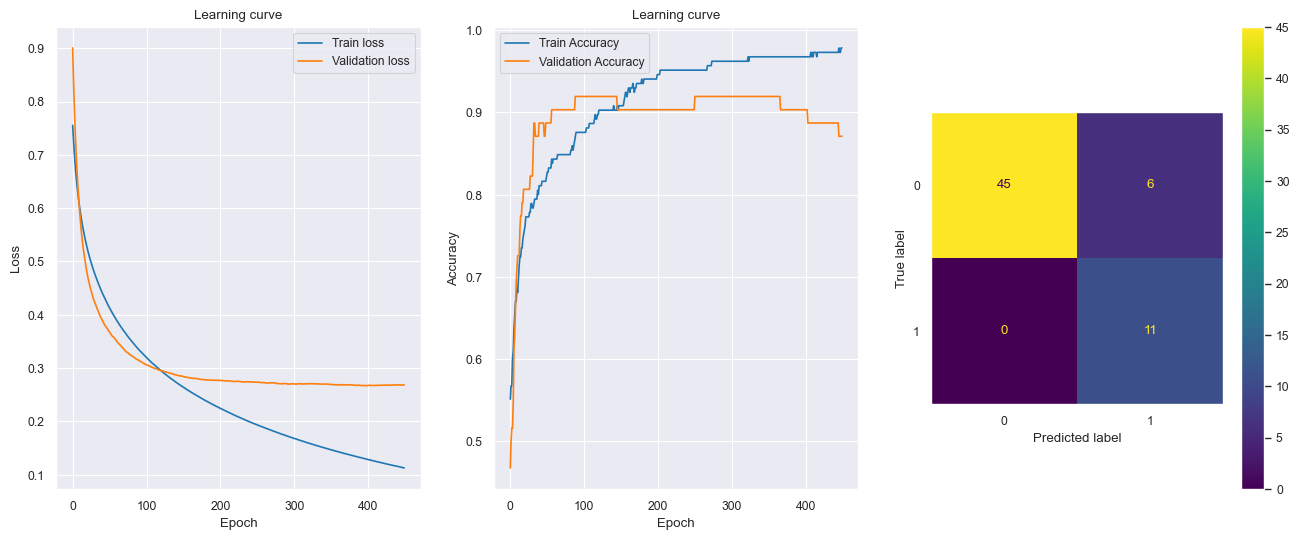

Fold 3 Init 0 Balanced Log Loss: 0.3339
Fold 3 Init 1 Balanced Log Loss: 0.2598
Fold 3 Init 2 Balanced Log Loss: 0.2399
Fold 3 Init 3 Balanced Log Loss: 0.2675
Fold 3 Init 4 Balanced Log Loss: 0.2261
Fold 3 Init 5 Balanced Log Loss: 0.2852
Fold 3 Init 6 Balanced Log Loss: 0.2659
Fold 3 Init 7 Balanced Log Loss: 0.2500
Fold 3 Init 8 Balanced Log Loss: 0.3033
Fold 3 Init 9 Balanced Log Loss: 0.2465
Fold 3 Balanced Log Loss: 0.2261
Fold 3 Accuracy: 0.8870967741935484


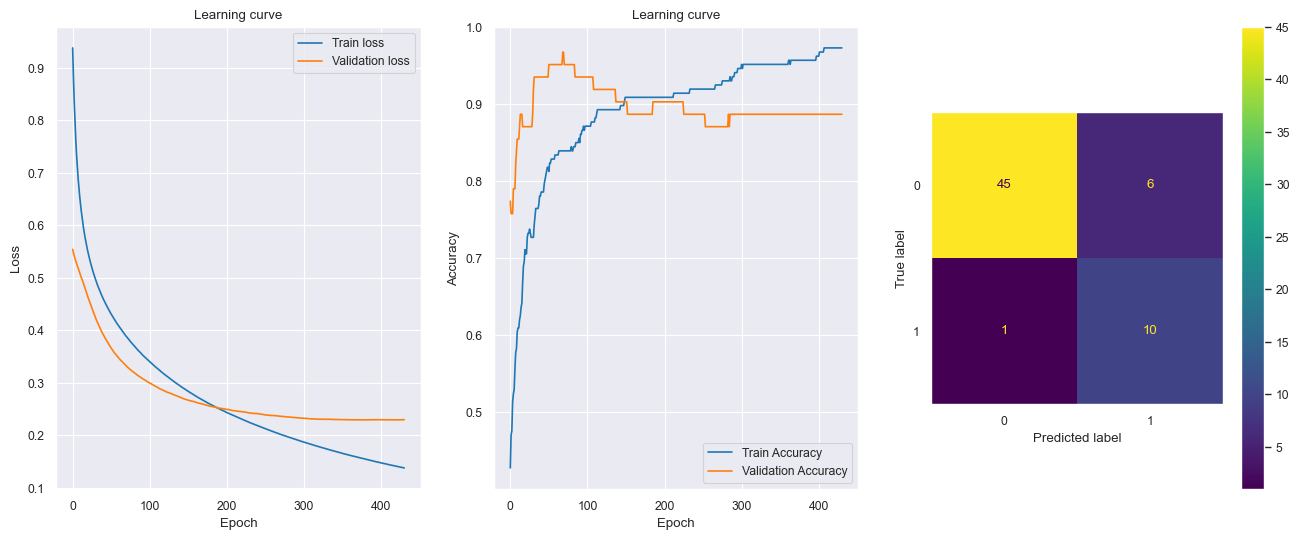

Fold 4 Init 0 Balanced Log Loss: 0.2292
Fold 4 Init 1 Balanced Log Loss: 0.2119
Fold 4 Init 2 Balanced Log Loss: 0.2957
Fold 4 Init 3 Balanced Log Loss: 0.2975
Fold 4 Init 4 Balanced Log Loss: 0.2662
Fold 4 Init 5 Balanced Log Loss: 0.3089
Fold 4 Init 6 Balanced Log Loss: 0.3414
Fold 4 Init 7 Balanced Log Loss: 0.2468
Fold 4 Init 8 Balanced Log Loss: 0.2692
Fold 4 Init 9 Balanced Log Loss: 0.2951
Fold 4 Balanced Log Loss: 0.2119
Fold 4 Accuracy: 0.8709677419354839


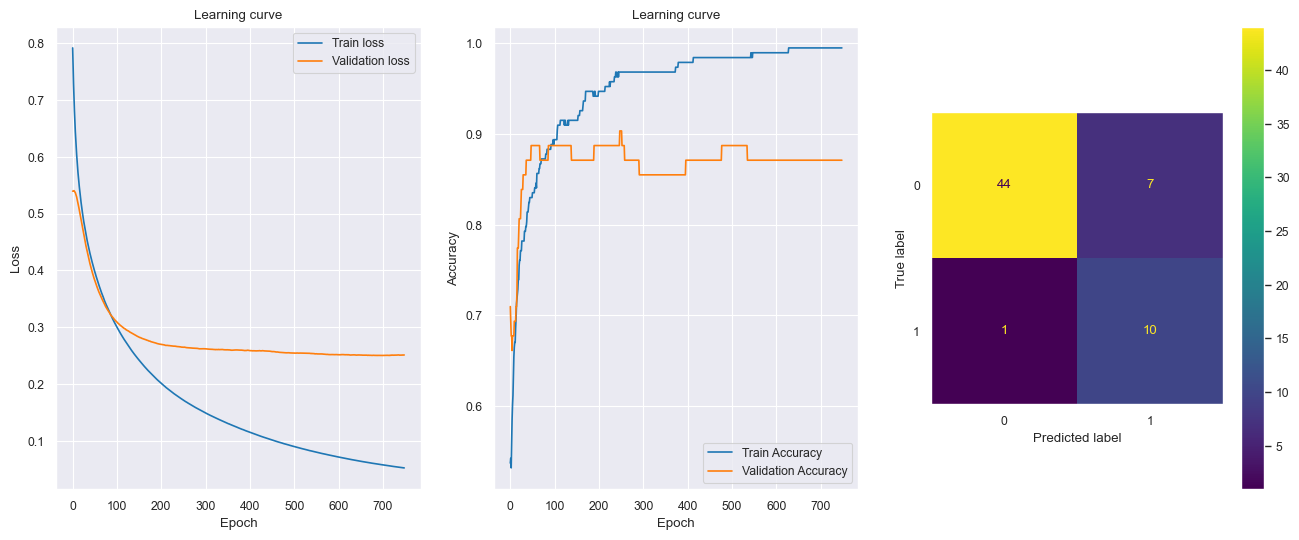

Best Fold: 0
Best Balanced Log Loss: 0.12057142531014635

CPU times: user 5min 34s, sys: 39.3 s, total: 6min 14s
Wall time: 5min 14s


In [32]:
%%time

# Encode categorical features
le = LabelEncoder()
X['EJ'] = le.fit_transform(X['EJ'])

cv = ImbalancedBinaryCVSplit(X, y, test_size=0.1, random_state=random_state)

cv_data = []
best_score = 100
best_fold = None
best_model = None
for fold, (X_train, X_test, y_train, y_test) in cv.split():
    # Impute missing values
    knn_imputer = KNNImputer(n_neighbors=5)
    X_train = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(knn_imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

    # Remove outliers
    X_train, y_train = remove_outliers(X_train, y_train, random_state=random_state)

    # Scale features
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

    # PCA
    pca = PCA(n_components=28, random_state=random_state)
    X_train = pd.DataFrame(pca.fit_transform(X_train), index=X_train.index)
    X_test = pd.DataFrame(pca.transform(X_test), index=X_test.index)
    
    # Multiple initializations
    n_init = 10 #! CHANGED N INITIALIZATIONS

    init_best_score = 100
    history = None
    init_best_model = None
    for init in range(n_init):
        # Neural Network Architecture
        model = Sequential()
        model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        # Compile Neural Network
        opt = SGD(learning_rate=0.01)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

        # Callbacks
        es = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

        # Train Neural Network
        h = model.fit(X_train, y_train, epochs=10000, batch_size=32, 
                      callbacks=es, verbose=0, validation_data=(X_test, y_test))

        # Evaluate Initializations
        y_score = model.predict(X_test, verbose=0)
        score = balanced_logloss(y_test, y_score)
        print(f'Fold {fold} Init {init} Balanced Log Loss: {score:.4f}')
        
        # Save best initialization
        if score < init_best_score:
            init_best_score = score
            init_best_model = model
            history = h
    
    # Evaluate Neural Network
    y_score = init_best_model.predict(X_test, verbose=0)
    y_pred = np.where(y_score > 0.5, 1, 0)
    score = balanced_logloss(y_test, y_score)
    print(f'Fold {fold} Balanced Log Loss: {score:.4f}')
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Fold {fold} Accuracy: {accuracy}')

    # Save data for plotting
    cv_data.append({
        'label_encoder' : le,
        'knn_imputer' : knn_imputer,
        'scaler' : scaler,
        'pca' : pca,
        'model' : init_best_model
    })

    # Save best model
    if score < best_score:
        best_score = score
        best_fold = fold
        best_model = init_best_model

    # Plot learning curves
    fig, axs = plt.subplots(1, 3, figsize=(16, 6))

    plt.subplot(131)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(132)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    ax = plt.subplot(133)
    ConfusionMatrixDisplay(cm).plot(ax=ax)
    plt.grid(False)
    plt.show()

# Print best model
print(f'Best Fold: {best_fold}')
print(f'Best Balanced Log Loss: {best_score}\n')

In [33]:
cv_data[best_fold]

{'label_encoder': LabelEncoder(),
 'knn_imputer': KNNImputer(),
 'scaler': StandardScaler(),
 'pca': PCA(n_components=28, random_state=42),
 'model': <keras.engine.sequential.Sequential at 0x292f429e0>}

In [34]:
test_scaled = cv_data[best_fold]['scaler'].transform(test)
test_pca = cv_data[best_fold]['pca'].transform(test_scaled)
test_pred = cv_data[best_fold]['model'].predict(test_pca, verbose=0)
test_pred

/Users/brunomotta/miniconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


array([[0.9999979],
       [0.9999979],
       [0.9999979],
       [0.9999979],
       [0.9999979]], dtype=float32)

Fold 0 Init 0 Balanced Log Loss: 0.2194
Fold 0 Init 1 Balanced Log Loss: 0.2352
Fold 0 Init 2 Balanced Log Loss: 0.2250
Fold 0 Init 3 Balanced Log Loss: 0.2530
Fold 0 Init 4 Balanced Log Loss: 0.2824
Fold 0 Init 5 Balanced Log Loss: 0.2167
Fold 0 Init 6 Balanced Log Loss: 0.2483
Fold 0 Init 7 Balanced Log Loss: 0.2812
Fold 0 Init 8 Balanced Log Loss: 0.2408
Fold 0 Init 9 Balanced Log Loss: 0.2947
Fold 0 Balanced Log Loss: 0.2167
Fold 0 Accuracy: 0.9032258064516129


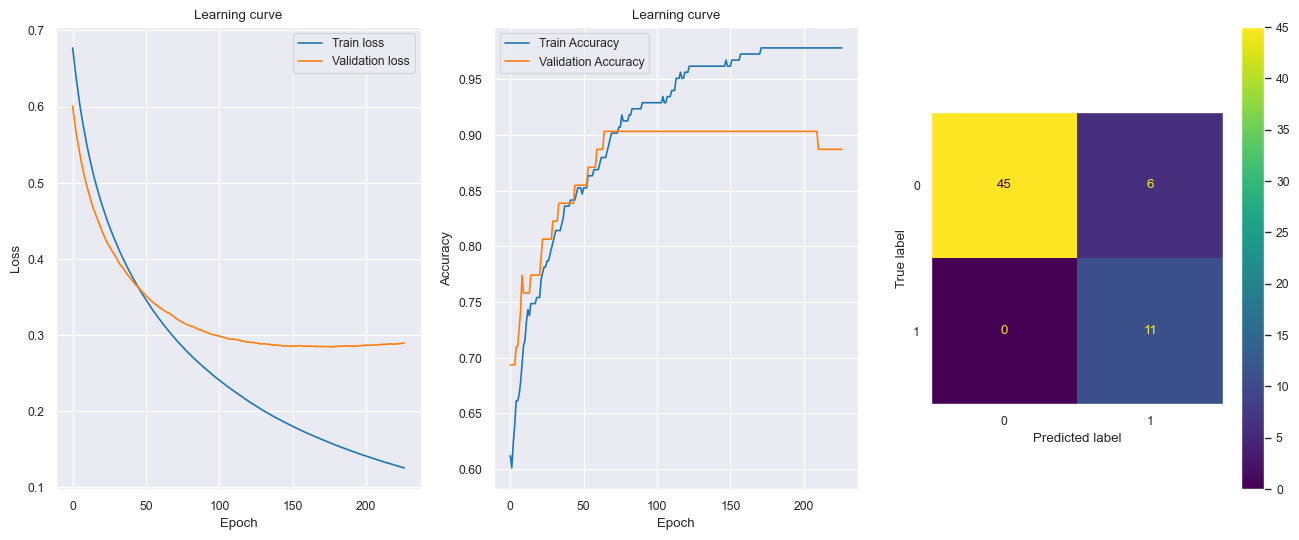

Fold 1 Init 0 Balanced Log Loss: 0.3030
Fold 1 Init 1 Balanced Log Loss: 0.2590
Fold 1 Init 2 Balanced Log Loss: 0.2757
Fold 1 Init 3 Balanced Log Loss: 0.2418
Fold 1 Init 4 Balanced Log Loss: 0.2368
Fold 1 Init 5 Balanced Log Loss: 0.1603
Fold 1 Init 6 Balanced Log Loss: 0.2352
Fold 1 Init 7 Balanced Log Loss: 0.2885
Fold 1 Init 8 Balanced Log Loss: 0.2429
Fold 1 Init 9 Balanced Log Loss: 0.2803
Fold 1 Balanced Log Loss: 0.1603
Fold 1 Accuracy: 0.9193548387096774


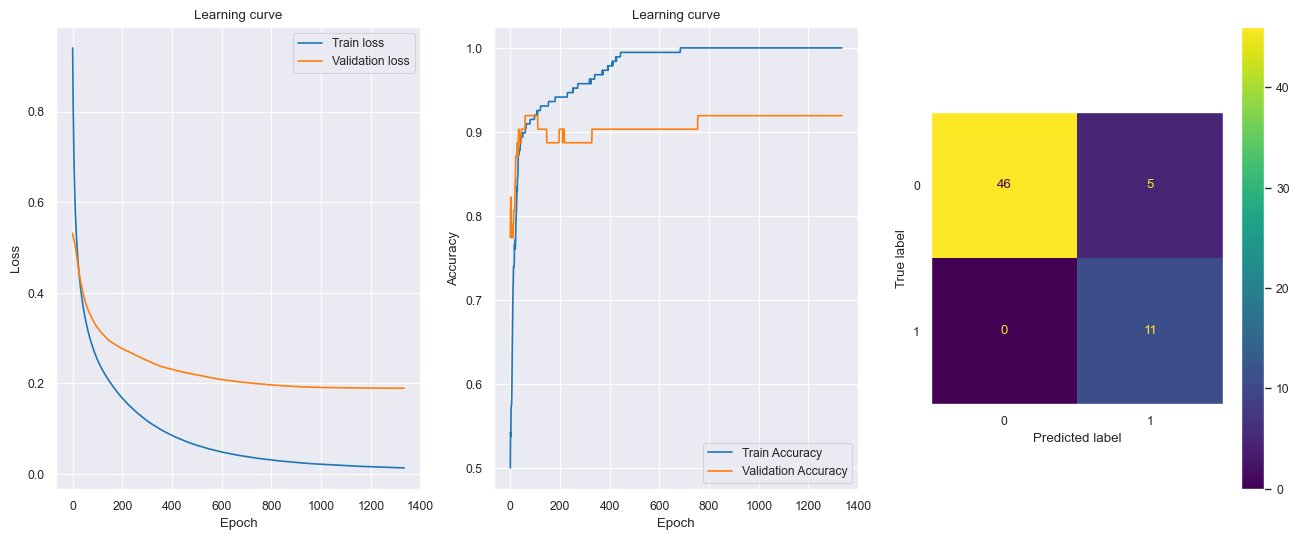

Fold 2 Init 0 Balanced Log Loss: 0.2811
Fold 2 Init 1 Balanced Log Loss: 0.2182
Fold 2 Init 2 Balanced Log Loss: 0.1974
Fold 2 Init 3 Balanced Log Loss: 0.3079
Fold 2 Init 4 Balanced Log Loss: 0.2731
Fold 2 Init 5 Balanced Log Loss: 0.1922
Fold 2 Init 6 Balanced Log Loss: 0.1500
Fold 2 Init 7 Balanced Log Loss: 0.2709
Fold 2 Init 8 Balanced Log Loss: 0.1738
Fold 2 Init 9 Balanced Log Loss: 0.2319
Fold 2 Balanced Log Loss: 0.1500
Fold 2 Accuracy: 0.8709677419354839


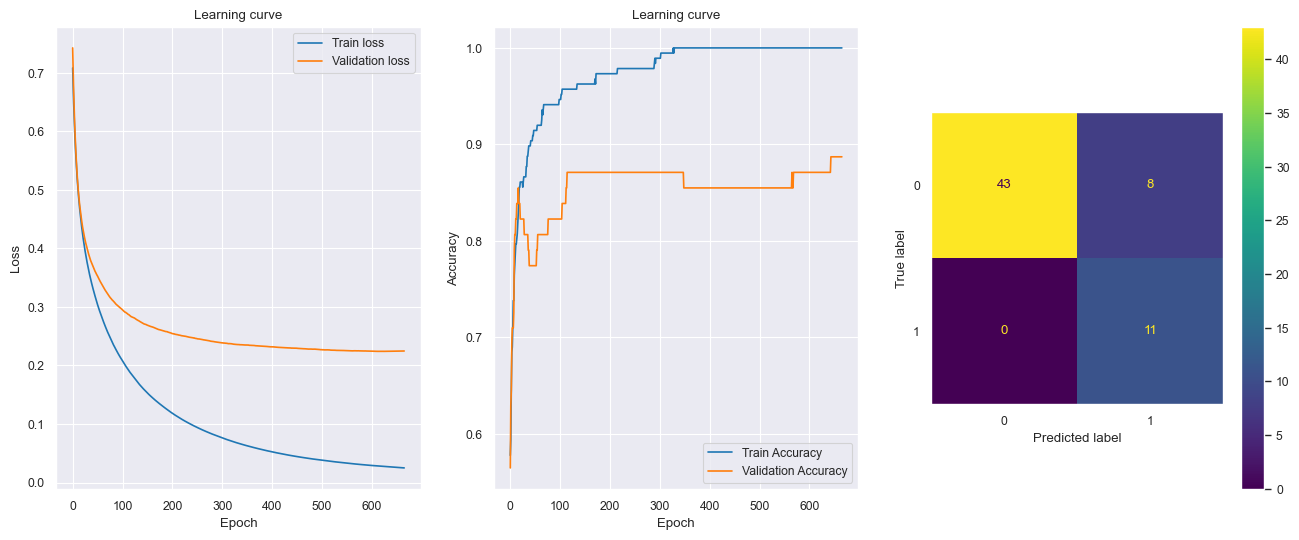

Fold 3 Init 0 Balanced Log Loss: 0.2209
Fold 3 Init 1 Balanced Log Loss: 0.1984
Fold 3 Init 2 Balanced Log Loss: 0.2676
Fold 3 Init 3 Balanced Log Loss: 0.2391
Fold 3 Init 4 Balanced Log Loss: 0.2007
Fold 3 Init 5 Balanced Log Loss: 0.2378
Fold 3 Init 6 Balanced Log Loss: 0.1938
Fold 3 Init 7 Balanced Log Loss: 0.2700
Fold 3 Init 8 Balanced Log Loss: 0.2220
Fold 3 Init 9 Balanced Log Loss: 0.2304
Fold 3 Balanced Log Loss: 0.1938
Fold 3 Accuracy: 0.9193548387096774


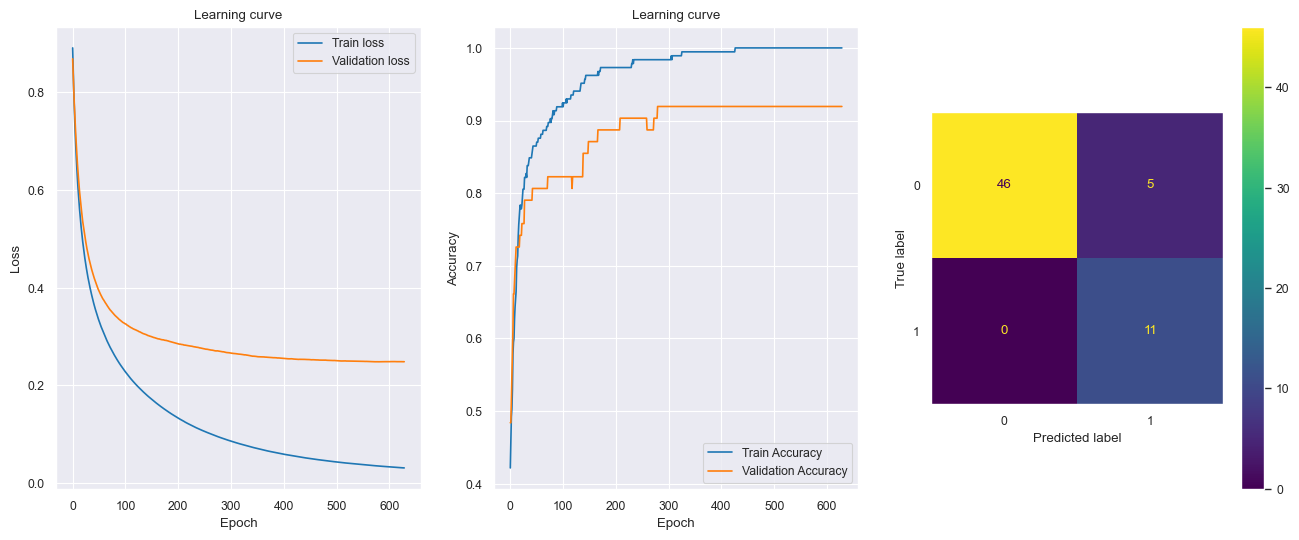

Fold 4 Init 0 Balanced Log Loss: 0.3305
Fold 4 Init 1 Balanced Log Loss: 0.2645
Fold 4 Init 2 Balanced Log Loss: 0.2798
Fold 4 Init 3 Balanced Log Loss: 0.2535
Fold 4 Init 4 Balanced Log Loss: 0.2635
Fold 4 Init 5 Balanced Log Loss: 0.2486
Fold 4 Init 6 Balanced Log Loss: 0.2584
Fold 4 Init 7 Balanced Log Loss: 0.3244
Fold 4 Init 8 Balanced Log Loss: 0.2787
Fold 4 Init 9 Balanced Log Loss: 0.3073
Fold 4 Balanced Log Loss: 0.2486
Fold 4 Accuracy: 0.8548387096774194


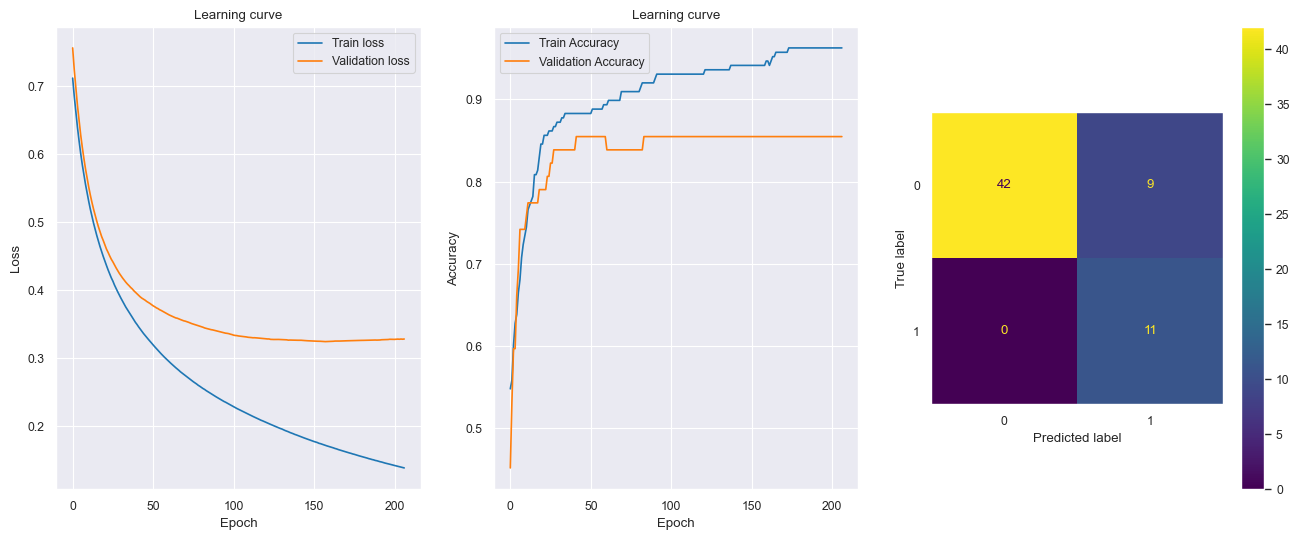

Best Fold: 2
Best Balanced Log Loss: 0.15002409859633137

CPU times: user 4min 32s, sys: 32.7 s, total: 5min 4s
Wall time: 4min 13s


In [35]:
%%time

# Encode categorical features
le = LabelEncoder()
X['EJ'] = le.fit_transform(X['EJ'])

cv = ImbalancedBinaryCVSplit(X, y, test_size=0.1, random_state=random_state)

cv_data = []
best_score = 100
best_fold = None
best_model = None
for fold, (X_train, X_test, y_train, y_test) in cv.split():
    # Impute missing values
    knn_imputer = KNNImputer(n_neighbors=5)
    X_train = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(knn_imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

    # Remove outliers
    X_train, y_train = remove_outliers(X_train, y_train, random_state=random_state)

    # Scale features
    scaler = PowerTransformer() #! CHANGED SCALER
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

    # PCA
    pca = PCA(n_components=28, random_state=random_state)
    X_train = pd.DataFrame(pca.fit_transform(X_train), index=X_train.index)
    X_test = pd.DataFrame(pca.transform(X_test), index=X_test.index)
    
    # Multiple initializations
    n_init = 10

    init_best_score = 100
    history = None
    init_best_model = None
    for init in range(n_init):
        # Neural Network Architecture
        model = Sequential()
        model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        # Compile Neural Network
        opt = SGD(learning_rate=0.01)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

        # Callbacks
        es = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

        # Train Neural Network
        h = model.fit(X_train, y_train, epochs=10000, batch_size=32, 
                      callbacks=es, verbose=0, validation_data=(X_test, y_test))

        # Evaluate Initializations
        y_score = model.predict(X_test, verbose=0)
        score = balanced_logloss(y_test, y_score)
        print(f'Fold {fold} Init {init} Balanced Log Loss: {score:.4f}')
        
        # Save best initialization
        if score < init_best_score:
            init_best_score = score
            init_best_model = model
            history = h
    
    # Evaluate Neural Network
    y_score = init_best_model.predict(X_test, verbose=0)
    y_pred = np.where(y_score > 0.5, 1, 0)
    score = balanced_logloss(y_test, y_score)
    print(f'Fold {fold} Balanced Log Loss: {score:.4f}')
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Fold {fold} Accuracy: {accuracy}')

    # Save data for plotting
    cv_data.append({
        'label_encoder' : le,
        'knn_imputer' : knn_imputer,
        'scaler' : scaler,
        'pca' : pca,
        'model' : init_best_model
    })

    # Save best model
    if score < best_score:
        best_score = score
        best_fold = fold
        best_model = init_best_model

    # Plot learning curves
    fig, axs = plt.subplots(1, 3, figsize=(16, 6))

    plt.subplot(131)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(132)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    ax = plt.subplot(133)
    ConfusionMatrixDisplay(cm).plot(ax=ax)
    plt.grid(False)
    plt.show()

# Print best model
print(f'Best Fold: {best_fold}')
print(f'Best Balanced Log Loss: {best_score}\n')

In [36]:
cv_data[best_fold]

{'label_encoder': LabelEncoder(),
 'knn_imputer': KNNImputer(),
 'scaler': PowerTransformer(),
 'pca': PCA(n_components=28, random_state=42),
 'model': <keras.engine.sequential.Sequential at 0x297f81600>}

In [37]:
test_scaled = cv_data[best_fold]['scaler'].transform(test)
test_pca = cv_data[best_fold]['pca'].transform(test_scaled)
test_pred = cv_data[best_fold]['model'].predict(test_pca, verbose=0)
test_pred

/Users/brunomotta/miniconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

# Add custom loss function

In [104]:
def custom_log_loss(y_true, y_pred):
    # Extract the predicted probabilities for each class
    y_pred_pos = y_pred
    y_pred_neg = 1 - y_pred

    # Calculate the class frequencies
    n_pos = K.cast(K.sum(y_true), dtype=K.floatx())
    n_neg = K.cast(K.sum(1 - y_true), dtype=K.floatx())

    # Calculate the inverse of the class frequencies
    w_pos = 1 / n_pos
    w_neg = 1 / n_neg

    # Cast to consistent data types
    w_pos = K.cast(w_pos, dtype=K.floatx())
    w_neg = K.cast(w_neg, dtype=K.floatx())
    y_true = K.cast(y_true, dtype=K.floatx())
    y_pred_pos = K.cast(y_pred_pos, dtype=K.floatx())
    y_pred_neg = K.cast(y_pred_neg, dtype=K.floatx())

    # Apply the balanced log loss formula with inverse class frequencies
    loss_1 = K.switch(K.equal(n_pos, 0), K.cast(0, dtype=K.floatx()), (-w_pos * K.sum(y_true * K.log(y_pred_pos))))
    loss_2 = K.switch(K.equal(n_neg, 0), K.cast(0, dtype=K.floatx()), (-w_neg * K.sum((1 - y_true) * K.log(y_pred_neg))))
    loss = (loss_1 + loss_2) / 2
    return loss


In [106]:
def balanced_log_loss(y_true, y_pred):
    # Ensure y_true and y_pred are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    
    # Calculate the quantities of positive and negative classes
    quantity_pos = np.sum(y_true)
    quantity_neg = len(y_true) - quantity_pos

    # Calculate the inverse of the quantities
    w_pos = 1 / quantity_pos
    w_neg = 1 / quantity_neg

    # Apply the balanced log loss formula with inverse quantities of each class
    loss_1 = -(w_pos * np.sum(y_true * np.log(y_pred)))
    loss_2 = -(w_neg * np.sum((1 - y_true) * np.log(1 - y_pred)))

    # Return the average loss
    loss = (loss_1 + loss_2) / 2
    return loss


In [107]:
def balanced_log_loss_gpt(y_true, y_pred):
    # Ensure y_true and y_pred are 1-dimensional
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    
    # Calculate the quantities of positive and negative classes
    quantity_pos = np.sum(y_true)
    quantity_neg = len(y_true) - quantity_pos

    # Calculate the inverse of the quantities
    w_pos = 1 / quantity_pos
    w_neg = 1 / quantity_neg

    # Apply the balanced log loss formula with inverse quantities
    loss = -(w_pos * y_true * np.log(y_pred) + w_neg * (1 - y_true) * np.log(1 - y_pred))
    return np.mean(loss)


In [109]:
balanced_log_loss(y_test, y_score)

0.3230358243823622

In [110]:
balanced_log_loss_gpt(y_test, y_score)

0.010420510463947171

Epoch 1/10000
6/6 [==============================] - 0s 17ms/step - loss: 0.8647 - custom_log_loss: 0.8652 - accuracy: 0.5160 - val_loss: 1.1906 - val_custom_log_loss: 0.9236 - val_accuracy: 0.2258
Epoch 2/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.8212 - custom_log_loss: 0.8178 - accuracy: 0.5213 - val_loss: 1.1163 - val_custom_log_loss: 0.8812 - val_accuracy: 0.2419
Epoch 3/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.7825 - custom_log_loss: 0.7799 - accuracy: 0.5426 - val_loss: 1.0504 - val_custom_log_loss: 0.8435 - val_accuracy: 0.2581
Epoch 4/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.7485 - custom_log_loss: 0.7435 - accuracy: 0.5798 - val_loss: 0.9910 - val_custom_log_loss: 0.8092 - val_accuracy: 0.2903
Epoch 5/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.7184 - custom_log_loss: 0.7038 - accuracy: 0.6011 - val_loss: 0.9392 - val_custom_log_loss: 0.7791 - val_accuracy: 0.3065
Epoch 6/10000


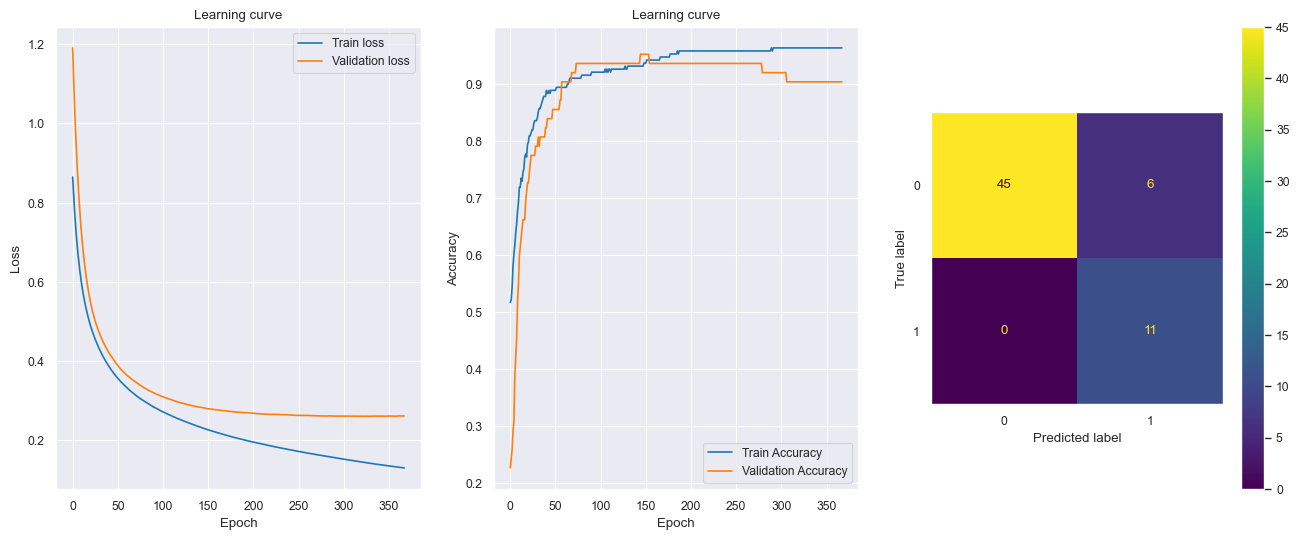

Epoch 1/10000
6/6 [==============================] - 0s 16ms/step - loss: 0.8156 - custom_log_loss: 0.8096 - accuracy: 0.4706 - val_loss: 0.7249 - val_custom_log_loss: 0.6745 - val_accuracy: 0.5484
Epoch 2/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.7916 - custom_log_loss: 0.7856 - accuracy: 0.4813 - val_loss: 0.7063 - val_custom_log_loss: 0.6577 - val_accuracy: 0.5484
Epoch 3/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.7689 - custom_log_loss: 0.7759 - accuracy: 0.4920 - val_loss: 0.6894 - val_custom_log_loss: 0.6420 - val_accuracy: 0.5645
Epoch 4/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.7478 - custom_log_loss: 0.7458 - accuracy: 0.5027 - val_loss: 0.6738 - val_custom_log_loss: 0.6274 - val_accuracy: 0.5645
Epoch 5/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.7290 - custom_log_loss: 0.7427 - accuracy: 0.5455 - val_loss: 0.6599 - val_custom_log_loss: 0.6141 - val_accuracy: 0.5968
Epoch 6/10000


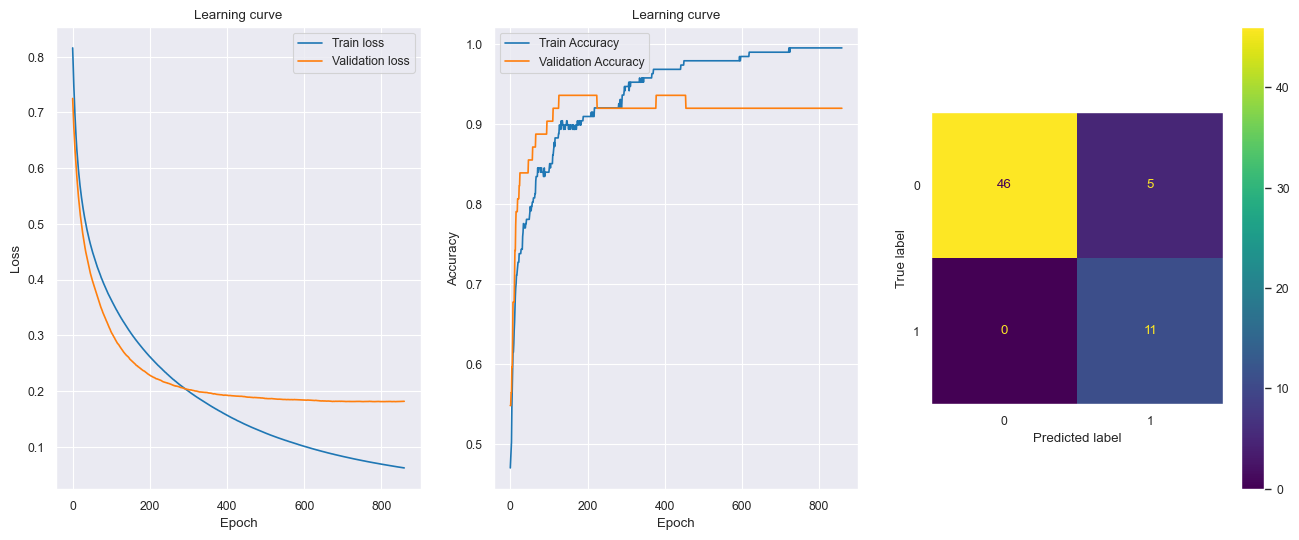

Epoch 1/10000
6/6 [==============================] - 0s 17ms/step - loss: 0.7745 - custom_log_loss: 0.7681 - accuracy: 0.5266 - val_loss: 1.0099 - val_custom_log_loss: 0.7515 - val_accuracy: 0.4032
Epoch 2/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.7481 - custom_log_loss: 0.7341 - accuracy: 0.5319 - val_loss: 0.9616 - val_custom_log_loss: 0.7254 - val_accuracy: 0.4194
Epoch 3/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.7255 - custom_log_loss: 0.7213 - accuracy: 0.5638 - val_loss: 0.9184 - val_custom_log_loss: 0.7021 - val_accuracy: 0.4194
Epoch 4/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.7053 - custom_log_loss: 0.7046 - accuracy: 0.5851 - val_loss: 0.8798 - val_custom_log_loss: 0.6810 - val_accuracy: 0.4516
Epoch 5/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.6867 - custom_log_loss: 0.6936 - accuracy: 0.6064 - val_loss: 0.8450 - val_custom_log_loss: 0.6620 - val_accuracy: 0.4839
Epoch 6/10000


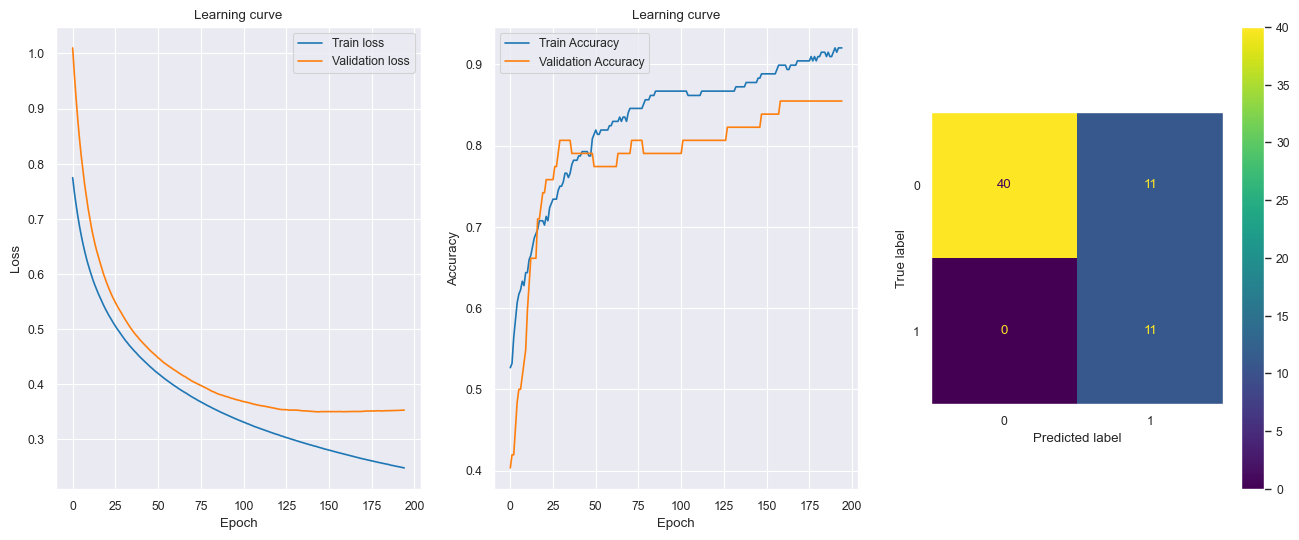

Epoch 1/10000
6/6 [==============================] - 0s 16ms/step - loss: 0.8388 - custom_log_loss: 0.8434 - accuracy: 0.4278 - val_loss: 0.8000 - val_custom_log_loss: 0.7571 - val_accuracy: 0.4839
Epoch 2/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.8066 - custom_log_loss: 0.8045 - accuracy: 0.4385 - val_loss: 0.7833 - val_custom_log_loss: 0.7290 - val_accuracy: 0.5000
Epoch 3/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.7772 - custom_log_loss: 0.7764 - accuracy: 0.4599 - val_loss: 0.7663 - val_custom_log_loss: 0.7034 - val_accuracy: 0.5161
Epoch 4/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.7506 - custom_log_loss: 0.7498 - accuracy: 0.4706 - val_loss: 0.7504 - val_custom_log_loss: 0.6800 - val_accuracy: 0.5484
Epoch 5/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.7268 - custom_log_loss: 0.7247 - accuracy: 0.5294 - val_loss: 0.7352 - val_custom_log_loss: 0.6587 - val_accuracy: 0.5806
Epoch 6/10000


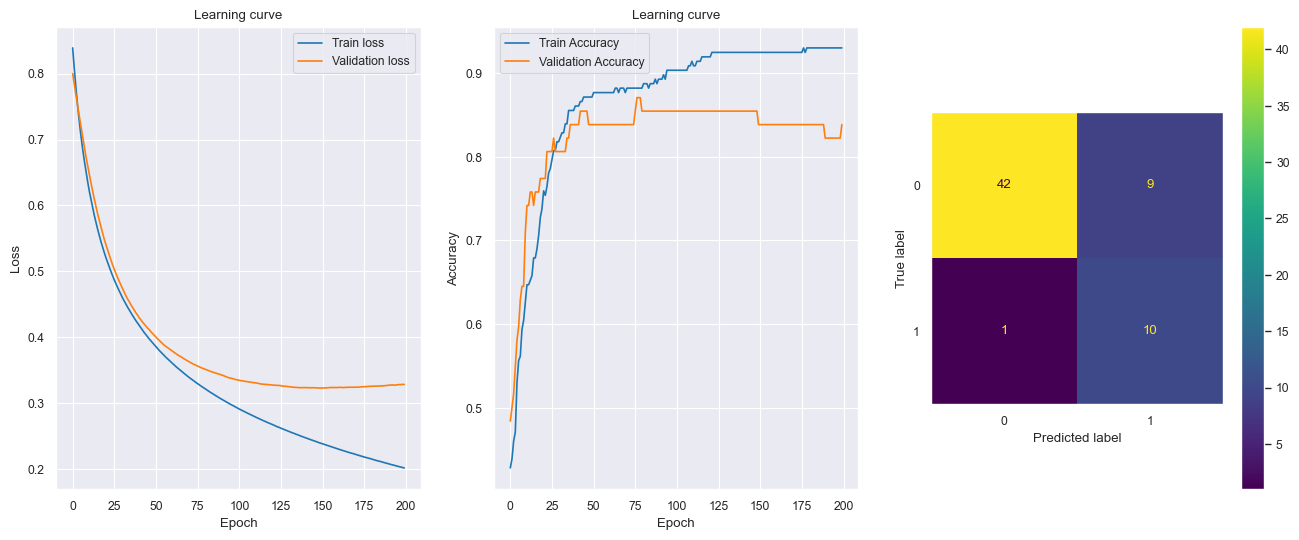

Epoch 1/10000
6/6 [==============================] - 0s 16ms/step - loss: 0.8188 - custom_log_loss: 0.8050 - accuracy: 0.4840 - val_loss: 1.0023 - val_custom_log_loss: 0.9025 - val_accuracy: 0.3710
Epoch 2/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.7923 - custom_log_loss: 0.7912 - accuracy: 0.5000 - val_loss: 0.9498 - val_custom_log_loss: 0.8757 - val_accuracy: 0.4194
Epoch 3/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.7684 - custom_log_loss: 0.7665 - accuracy: 0.5053 - val_loss: 0.9039 - val_custom_log_loss: 0.8520 - val_accuracy: 0.4355
Epoch 4/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.7479 - custom_log_loss: 0.7460 - accuracy: 0.5266 - val_loss: 0.8624 - val_custom_log_loss: 0.8304 - val_accuracy: 0.4516
Epoch 5/10000
6/6 [==============================] - 0s 3ms/step - loss: 0.7287 - custom_log_loss: 0.7228 - accuracy: 0.5372 - val_loss: 0.8260 - val_custom_log_loss: 0.8111 - val_accuracy: 0.4677
Epoch 6/10000


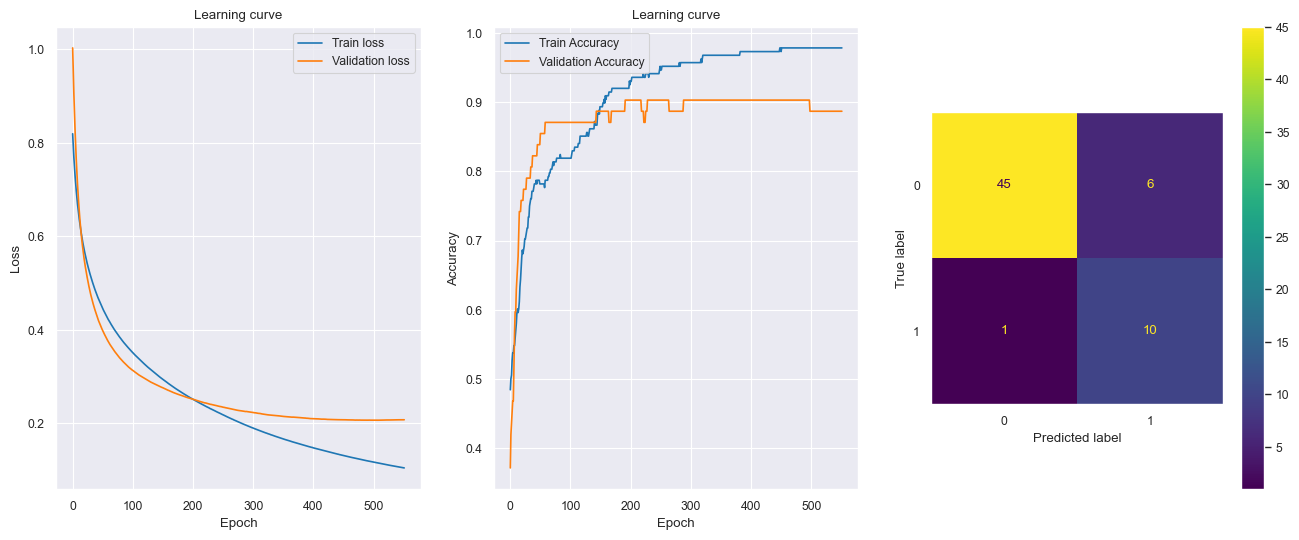

Best Fold: 1
Best Balanced Log Loss: 0.13758357476218147

CPU times: user 48.6 s, sys: 6.26 s, total: 54.9 s
Wall time: 39.7 s


In [113]:
%%time

# Encode categorical features
le = LabelEncoder()
X['EJ'] = le.fit_transform(X['EJ'])

cv = ImbalancedBinaryCVSplit(X, y, test_size=0.1, random_state=random_state)

cv_data = []
best_score = 100
best_fold = None
best_model = None
for fold, (X_train, X_test, y_train, y_test) in cv.split():
    # Impute missing values
    knn_imputer = KNNImputer(n_neighbors=5)
    X_train = pd.DataFrame(knn_imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(knn_imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

    # Remove outliers
    X_train, y_train = remove_outliers(X_train, y_train, random_state=random_state)

    # Scale features
    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

    # PCA
    pca = PCA(n_components=28, random_state=random_state)
    X_train = pd.DataFrame(pca.fit_transform(X_train), index=X_train.index)
    X_test = pd.DataFrame(pca.transform(X_test), index=X_test.index)
    
    # Multiple initializations
    n_init = 1

    init_best_score = 100
    history = None
    init_best_model = None
    for init in range(n_init):
        # Neural Network Architecture
        model = Sequential()
        model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
        model.add(Dense(1, activation='sigmoid'))

        # Compile Neural Network
        opt = SGD(learning_rate=0.01)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[custom_log_loss, 'accuracy'])

        # Callbacks
        es = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

        # Train Neural Network
        h = model.fit(X_train, y_train, epochs=10000, batch_size=32, 
                      callbacks=es, verbose=1, validation_data=(X_test, y_test))

        # Evaluate Initializations
        y_score = model.predict(X_test, verbose=0)
        score = balanced_log_loss(y_test, y_score)
        print(f'Fold {fold} Init {init} Balanced Log Loss: {score:.4f}')
        score_gpt = balanced_log_loss_gpt(y_test, y_score)
        print(f'Fold {fold} Init {init} Balanced Log Loss GPT: {score_gpt:.4f}')
        
        # Save best initialization
        if score < init_best_score:
            init_best_score = score
            init_best_model = model
            history = h
    
    # Evaluate Neural Network
    y_score = init_best_model.predict(X_test, verbose=0)
    y_pred = np.where(y_score > 0.5, 1, 0)
    score = balanced_log_loss(y_test, y_score)
    print(f'Fold {fold} Balanced Log Loss: {score:.4f}')
    score_gpt = balanced_log_loss_gpt(y_test, y_score)
    print(f'Fold {fold} Balanced Log Loss GPT: {score_gpt:.4f}')
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Fold {fold} Accuracy: {accuracy}')

    # Save data for plotting
    cv_data.append({
        'label_encoder' : le,
        'knn_imputer' : knn_imputer,
        'scaler' : scaler,
        'pca' : pca,
        'model' : init_best_model,
        'history' : history,
        'score' : score,
        'score_gpt' : score_gpt,
    })

    # Save best model
    if score < best_score:
        best_score = score
        best_fold = fold
        best_model = init_best_model

    # Plot learning curves
    fig, axs = plt.subplots(1, 3, figsize=(16, 6))

    plt.subplot(131)
    plt.plot(history.history['loss'], label='Train loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(132)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Learning curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    ax = plt.subplot(133)
    ConfusionMatrixDisplay(cm).plot(ax=ax)
    plt.grid(False)
    plt.show()

# Print best model
print(f'Best Fold: {best_fold}')
print(f'Best Balanced Log Loss: {best_score}\n')

In [10]:
cv_data[best_fold]

{'label_encoder': LabelEncoder(),
 'knn_imputer': KNNImputer(),
 'scaler': StandardScaler(),
 'pca': PCA(n_components=28, random_state=42),
 'model': <keras.engine.sequential.Sequential at 0x1778ff0d0>}

In [15]:
balanced_logloss(y_test, cv_data[-1]['model'].predict(X_test))

2/2 [==============================] - 0s 1ms/step


0.33276870604185305

In [16]:
log_loss(y_test, cv_data[-1]['model'].predict(X_test))

2/2 [==============================] - 0s 938us/step


0.3632373461540015

In [39]:
balanced_log_loss(y_test, cv_data[-1]['model'].predict(X_test))

2/2 [==============================] - 0s 1ms/step


0.010734474388446873

In [11]:
test_scaled = cv_data[best_fold]['scaler'].transform(test)
test_pca = cv_data[best_fold]['pca'].transform(test_scaled)
test_pred = cv_data[best_fold]['model'].predict(test_pca, verbose=0)
test_pred

/Users/brunomotta/miniconda3/envs/kaggle/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


array([[0.8981118],
       [0.8981118],
       [0.8981118],
       [0.8981118],
       [0.8981118]], dtype=float32)